🔗 [Репозиторий на GitHub](https://github.com/KirillShiryaev61/marketing_purchase_prediction.git)

# Проект: "Будут ли они покупать?" — Бинарная классификация для маркетинга

**Описание проекта:**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель проекта** — Предсказать вероятность покупки в течение `90 дней`.

**Описание данных:**

`apparel-purchases.csv` — Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента;
- `quantity` — количество единиц товара;
- `price` — цена товара;
- `category_ids` — идентификаторы категорий;
- `date` — дата покупки;
- `message_id` — идентификатор сообщения из рассылки.

>***Примечание к таблице:***
>
>*В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: `автотовары-аксессуары-освежители`), но также может
включать в начале списка маркер распродажи или маркер `женщинам/мужчинам`.*
>
>*Нумерация категорий сквозная для всех уровней, то есть `44` на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.*

---

`apparel-messages.csv` — Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки;
- `client_id` — идентификатор клиента;
- `message_id` — идентификатор сообщения;
- `event` — действие с сообщением *(`отправлено, открыто, покупка и т.д.`)*
- `channel` — канал рассылки;
- `date` — дата действия;
- `created_at` — дата-время полностью.

---

`target.csv` — Целевой признак.

- `client_id` — идентификатор клиента;
- `target` — клиент совершил покупку в целевом периоде.

---

`full_campaign_daily_event.csv` — Агрегация общей базы рассылок по дням и типам событий.

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event*` — общее количество каждого события `event`;
- `nunique_event*` — количество уникальных `client_id` в каждом событии.


> ***Примечание к таблице:***
> 
>`*` — в именах колонок все типы событий `event`.

---

`full_campaign_daily_event_channel.csv` — Агрегация по дням с учетом событий и каналов рассылки.

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event*_channel*` — общее количество каждого события по каналам;
- `nunique_event*_channel*` — количество уникальных `client_id` по событиям и каналам.


> ***Примечание к таблице:***
> 
>`*` — в именах колонок есть все типы событий `event` и каналов рассылки `channel`.

**Ход исследования:**

- `Подготовка данных`: загрузка и изучение общей информации из представленных датасетов.


- `Предобработка данных и агрегирование признаков:`: агрегирование признаков для обучения моделей из сырых данных.


- `Исследовательский анализ данных`: изучение признаков, их распределение, поиск выбросов/аномалий в данных.


- `Корреляционный анализ`: изучение взимосвязей между входными признаками и целевыми, а также и между ними.


- `Использование пайплайнов`: написание пайплайнов для подготовки данных и обучения модели для упрощения и ускорения поиска лучшей модели и ее гиперпараметров.


- `Поиск лучшей модели`: грубый поиск лучших гиперпараметров с помощью `GridSearchCV`, поиск оптимального набора признака для моделей с помощью `RFECV`, более точный поиск лучших гиперпараметров и обучение моделей с помощью `BayesSearchCV`, обучение ансамблевой модели с применением `soft-voting`, тестирование итоговой модели и анализ результатов.


- `Анализ важности признаков`: анализ степени важности признаков их влияния на принятие решений моделью с помощью метода `SHAP`.


- `Общий вывод`: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Подготовка рабочей среды и вспомогательные функции:

### Импорт библиотек:

In [1]:
from IPython.display import display
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import anderson
import phik
import shap
import ast
from sklearn.metrics import (precision_score, 
                             recall_score, 
                             roc_auc_score, 
                             average_precision_score, 
                             confusion_matrix)
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler,
                                   FunctionTransformer)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     StratifiedKFold, 
                                     cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import warnings

### Настройки блокнота по умолчанию:

In [2]:
# Настройка стиля графиков по умолчанию
sns.set()
sns.set_context('paper')
# Убираем ограничение на кол-во отображаемых столбцов
pd.set_option('display.max_columns', None)
# Убираем ограничение на кол-во отображаемых символов в ячейке
pd.set_option('display.max_colwidth', None)
# Константа для random_state
RANDOM_STATE=6011994

### Функции:

In [3]:
# Функция для получения общей информации о датафрейме
def gen_info(df):
    '''
    Данная функция выводит общую информацию 
    о датафрейме, статистическое описание признаков
    и 5 рандомных строк.
    На ввод функция принимает переменную датафрейма.
    '''
    # Статистики по количественным признакам
    desc = df.describe().T

    # Вывод результатов
    print(df.info())
    display(desc)
    display(df.sample(5, random_state=RANDOM_STATE))

In [4]:
# Функция для поиска неявных дубликатов
def hidden_dup_search(df):
    '''
    Данная функция приводит значения категориальных 
    столбцов к единому стилю и выводит их уникальные 
    значения.
    На ввод функция принимает переменную датафрейма.
    '''
    
    # Список категориальных признаков
    df_cat_col = df.select_dtypes(include='object').columns.tolist()

    # Приводим все значения к единому стилю
    # и проверяем уникальные значения для 
    # точечной проработки при необходимости
    for feature in df_cat_col:
        df[feature] = df[feature].str.lower().str.replace(' ', '_')
        print(f'Уникальные значения признака: {str(feature)}')
        print(df[feature].unique())
        print()

In [5]:
# Функция для комплексного анализа количественного признака
def analyzis_quantity(df, x_label, y_label='Частота', target=None, 
                      hue=None, system=False, discrete=False, 
                      log_scale=False, title_hist=None, title_scatter=None):
    '''
    Данная функция выводит "коробочный" график и гистограмму 
    по указанному столбцу датафрейма и его статистические метрики.
    Аргументы функции:
    df - данные (pd.Series)
    x_label - подпись для оси Х
    y_label - подпись для оси Y (по умолчанию "Частота")
    target - целевая переменная для scatter-графика (если system=True)
    hue - переменная для цветового кодирования (если system=True)
    system - флаг для построения scatter-графика
    discrete - булевое значение, дискретные значение или нет.
    log_scale - логарифмическая шкала для гистограммы
    title_hist - заголовок для гистограммы и boxplot
    title_scatter - заголовок для scatter-графика
    '''

    # Названия для графиков по умолчанию
    if title_hist is None:
        title_hist = f"Распределение {df.name if hasattr(df, 'name') else 'входной признак'}"
    if title_scatter is None:
        target_name = target.name if hasattr(target, 'name') else 'таргета'
        feature_name = df.name if hasattr(df, 'name') else 'входной признак'
        title_scatter = f"Зависимость {target_name} от {feature_name}"
    
    # Создание составного графика: boxplot + histogram
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                          figsize=(6, 4.2), 
                                          gridspec_kw={'height_ratios': (.15, .85)})
    
    # Boxplot
    sns.boxplot(x=df, orient='h', ax=ax_box)
    ax_box.set(xlabel='')

    # Histogram
    n_bins = round(1 + math.log2(len(df))) if len(df) > 1 else 10
    sns.histplot(x=df, bins=n_bins, discrete=discrete, log_scale=log_scale, ax=ax_hist)

    # Общие настройки для основной фигуры
    ax_hist.set_xlabel(x_label, fontsize=10)
    ax_hist.set_ylabel(y_label, fontsize=10)
    ax_hist.tick_params(axis='both', which='major', labelsize=10)
    fig.suptitle(title_hist, fontsize=12, fontweight='bold', y=0.95)

    # Настройка тиков для дискретных значений
    if discrete == 'unique':
        unique_vals = np.sort(df.dropna().unique())
        ax_hist.set_xticks(unique_vals)
    elif discrete == 'non_unique':
        ax_hist.set_xticks(np.arange(df.min(), df.max() + 1, 1))

    # Отображение первой фигуры
    fig.tight_layout()

    # Scatter plot (если запрошено)
    if system:
        if hue is not None:
            fig_2, ax_2 = plt.subplots(figsize=(6.75, 4))
        else:
            fig_2, ax_2 = plt.subplots(figsize=(6, 4))
        sns.scatterplot(x=df, y=target, alpha=0.5, hue=hue, ax=ax_2)
        fig_2.suptitle(title_scatter, fontsize=12, fontweight='bold', y=0.95)
        ax_2.set_xlabel(x_label, fontsize=10)
        ax_2.set_ylabel(target.name if hasattr(target, 'name') else 'Целевая переменная', fontsize=10)
        ax_2.tick_params(axis='both', which='major', labelsize=10)
        if hue is not None:
            ax_2.legend(bbox_to_anchor=(1.025, 1), loc='upper left', fontsize=10)
        fig_2.tight_layout()

    # Отображение графика
    plt.show()

    # Вывод статистических метрик
    display(df.describe().to_frame().T)
        
    # Проверяем нормальность распределения
    result = anderson(df.dropna())
    
    if result.statistic < result.critical_values[2]:
        distr = 'Нормальное'
    else:
        distr = 'Не является нормальным'

    test_anderson = {'':['Статистика:', 
                         "Критические значения:", 
                         'Распределение'], 
                     'Тест на нормальность распределения (порог=0.05):': [result.statistic, 
                                                                          result.critical_values, 
                                                                          distr]
                    }
    display(pd.DataFrame(test_anderson).set_index(''))

In [6]:
# Функция для анализа категорийных значений

def analyzis_category(df, title=None, kind='bar'):
    '''
    Данная функция выводит столбчатый график
    по указанному столбцу датафрейма и его значения 
    в табличном виде.
    Аргументы функции:
    df - данные
    name - название графика
    kind - ориентация графика вертикальная или 
    горизонтальная, принимает значения "bar" и "barh".
    '''
    # Название для графика по умолчанию
    if title is None:
        title = f"Соотношение категорий {df.name if hasattr(df, 'name') else 'входного признака'}"
    
    # Подсчитываем количество каждого значения
    category_count = df.value_counts(ascending=True)

    # Создание столбчатого графика
    plot_bar = category_count.plot(kind=kind, figsize=(6, 4), grid=True)

    # Настройка заголовка и подписей
    if kind == 'bar':
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('')
        plt.ylabel('Частота', fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=0)
    
    else:
        plt.title(title, fontweight='bold', fontsize=12)
        plt.xlabel('Частота', fontsize=10)
        plt.ylabel('')
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.xticks(rotation=0)

    # Отображаем график
    plt.tight_layout()
    plt.show()

    # Вывод значений в табличном виде
    display(pd.DataFrame(category_count).reset_index())

In [7]:
# Фукнция для проверка зависимости категориального признака с таргетом
def cat_groupby(df, col, target):
    table = df.groupby(target, as_index=False, observed=False)[col].mean()
    display(pd.DataFrame(table).sort_values(by=col, ascending=False))

In [8]:
# Функция для компрессии данных
def compress(df, threshold, coef, method='power', dry=0):
    '''
    Функция для степенной копрессии данных,
    пики превышающие порог масштабируются c
    соответствнно размеру коэффициента.
    
    Аргументы:
    df - pd.Series (оригинальный признак для компрессии);
    threshold - порог срабатывания компрессора (передавать абсолютные значение);
    coef - степень сжатия (для метода power), 
    коэффициент ослабления силы сжатия (для метода log);
    method - метод сжатия (степенной - power, логарифмический - log);
    dry - доля подмешивания оригинальных значений, для ослабления сжатия.

    Вывод: pd.Series.
    '''
    mask = df > threshold
    compress_col = df.copy().astype('float64')
    
    if method == 'power':
        
        compress_col[mask] = threshold + (df[mask] - threshold) ** coef
    
    elif method == 'log':
        
        compress_col[mask] = threshold + np.log1p(df[mask] - threshold) * coef
    
    else:
        raise ValueError(f"Неподдерживаемый метод: '{method}'. Допустимые значения: 'power', 'log'")
    
    return df * dry + compress_col * (1 - dry)

In [9]:
# Функция для обработки колонки "category_ids"
def parse_category_ids(x):
    if pd.isna(x) or x == '' or x == '[]':
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            try:
                parsed = ast.literal_eval(x)
                return parsed if isinstance(parsed, list) else [parsed]
            except:
                # Если не парсится — считаем, что это одна категория
                return [x]
        else:
            # Просто строка без скобок — одна категория
            return [x]
    else:
        # Число или другой тип — оборачиваем
        return [x]

In [10]:
# Построение таблицы с расчитанным VIF
def vif_factor(data, columns):
    '''
    Данная функция расчитываем VIF-фактор
    для количественных признаков датафрейма.
    На ввод функция принимает:
    data - датафрейм
    columns - список количественных признаков.
    '''
    vif_data = pd.DataFrame()
    vif_data['input attribute'] = columns
    vif_data['vif'] = ([variance_inflation_factor(data[columns].values, i) 
                        for i in range(data[columns].shape[1])])
    return vif_data

In [11]:
# Вывод лучших результатов для каждой модели
def best_result(cv):
    result_search = pd.DataFrame(cv.cv_results_)
    result_search['model_type'] = result_search['param_model'].apply(lambda x: x.__class__.__name__)
    best_rows = result_search.loc[
        result_search.groupby('model_type')['rank_test_score'].idxmin()]
    return best_rows

## Общая информация о данных:

### Загрузка данных:

In [12]:
try:
    purchases = pd.read_csv('filtered_data/apparel-purchases.csv', parse_dates=['date'])
    messages = pd.read_csv('filtered_data/apparel-messages.csv', parse_dates=['date', 'created_at'])
    data = pd.read_csv('filtered_data/apparel-target_binary.csv')

except:
    print('The "filtered_data" folder with the data is missing.')

### Общая информация датафреме "purchases":

`apparel-purchases.csv` — Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента;
- `quantity` — количество единиц товара;
- `price` — цена товара;
- `category_ids` — идентификаторы категорий;
- `date` — дата покупки;
- `message_id` — идентификатор сообщения из рассылки.

>***Примечание к таблице:***
>
>*В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: `автотовары-аксессуары-освежители`), но также может
включать в начале списка маркер распродажи или маркер `женщинам/мужчинам`.*
>
>*Нумерация категорий сквозная для всех уровней, то есть `44` на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.*

In [13]:
gen_info(purchases)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB
None


count                           mean                    min  \
client_id  202208.0          1515915625596210944.0  1515915625468060928.0   
quantity   202208.0                       1.006483                    1.0   
price      202208.0                    1193.301516                    1.0   
date         202208  2023-03-17 02:49:35.739832064    2022-05-16 00:00:00   

                             25%                    50%  \
client_id  1515915625490081280.0  1515915625557177088.0   
quantity                     1.0                    1.0   
price                      352.0                  987.0   
date         2022-11-12 00:00:00    2023-04-12 00:00:00   

                             75%                    max               std  
client_id  1515915625624391936.0  1515915626010443520.0  145951436.369225  
quantity                     1.0                   30.0          0.184384  
price                     1699.0                85499.0       1342.252664  
date         2023-07-03 00:00:00    2024-02-16 00:00:00               NaN

client_id  quantity   price  \
58073   1515915625496692179         1   280.0   
103973  1515915625549990887         1  1609.0   
77151   1515915625590318373         1  2729.0   
24095   1515915625491809890         1   999.0   
74602   1515915625549395201         1    69.0   

                            category_ids       date  \
58073   ['5562', '5633', '5578', '1353'] 2022-11-16   
103973         ['4', '28', '260', '420'] 2023-04-14   
77151           ['2', '18', '61', '660'] 2022-12-23   
24095          ['2', '18', '243', '440'] 2022-07-15   
74602           ['4', '27', '84', '515'] 2022-12-22   

                                     message_id  
58073    1515915625496692179-7845-63733582f1bea  
103973  1515915625635928402-11796-643902bdb089b  
77151    1515915625590318373-8995-63a5b13239324  
24095    1515915625491809890-5456-62d102b999ab1  
74602    1515915625549395201-8902-63a2cf0fc93d5

### Общая информация датафреме "messages":

`apparel-messages.csv` — Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки;
- `client_id` — идентификатор клиента;
- `message_id` — идентификатор сообщения;
- `event` — действие с сообщением *(`отправлено, открыто, покупка и т.д.`)*
- `channel` — канал рассылки;
- `date` — дата действия;
- `created_at` — дата-время полностью.

In [14]:
gen_info(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB
None


count                           mean  \
bulk_campaign_id  12739798.0                   11604.587587   
client_id         12739798.0          1515915625574831616.0   
date                12739798  2023-06-05 02:46:08.357990400   
created_at          12739798  2023-06-05 13:58:11.168689408   

                                    min                    25%  \
bulk_campaign_id                  548.0                 8746.0   
client_id         1515915625468060928.0  1515915625489149440.0   
date                2022-05-19 00:00:00    2022-12-19 00:00:00   
created_at          2022-05-19 00:14:20    2022-12-19 12:46:30   

                                    50%                    75%  \
bulk_campaign_id                13516.0                14158.0   
client_id         1515915625503432192.0  1515915625591286272.0   
date                2023-07-20 00:00:00    2023-11-21 00:00:00   
created_at          2023-07-20 17:21:54    2023-11-21 18:13:05   

                                    max              std  
bulk_campaign_id                14657.0      3259.211131  
client_id         1515915626010288640.0  326551798.15769  
date                2024-02-15 00:00:00              NaN  
created_at          2024-02-15 23:58:40              NaN

bulk_campaign_id            client_id  \
8065246              13868  1515915625960606941   
9625097              14172  1515915625635428260   
4070649              10218  1515915625644148718   
11451938             14459  1515915625501063976   
8232080              13907  1515915625561071155   

                                       message_id event      channel  \
8065246   1515915625960606941-13868-6513ccae34cef  open        email   
9625097   1515915625635428260-14172-655f230ebfc49  send  mobile_push   
4070649   1515915625644148718-10218-63ef56f794a03  send        email   
11451938  1515915625501063976-14459-659fa8c38c27d  open        email   
8232080   1515915625561071155-13907-651d6226adc4c  send  mobile_push   

               date          created_at  
8065246  2023-09-27 2023-09-27 10:36:29  
9625097  2023-11-23 2023-11-23 11:20:19  
4070649  2023-02-17 2023-02-17 10:38:56  
11451938 2024-01-11 2024-01-11 08:56:06  
8232080  2023-10-04 2023-10-04 16:28:37

Из-за размера датасета `Pandas` скрыл информацию о количестве `non-null` значений, оценим количество пропусков отдельно.

In [15]:
messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропуски отсутствуют.

### Общая информация датафреме "data":

`target.csv` — Целевой признак.

- `client_id` — идентификатор клиента;
- `target` — клиент совершил покупку в целевом периоде.

In [16]:
gen_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
None


count          mean           std           min           25%  \
client_id  49849.0  1.515916e+18  1.487947e+08  1.515916e+18  1.515916e+18   
target     49849.0  1.927822e-02  1.375025e-01  0.000000e+00  0.000000e+00   

                    50%           75%           max  
client_id  1.515916e+18  1.515916e+18  1.515916e+18  
target     0.000000e+00  0.000000e+00  1.000000e+00

client_id  target
30343  1515915625573994353       0
659    1515915625468112615       0
14581  1515915625490695181       0
9550   1515915625489026256       0
32264  1515915625581886892       0

### Вывод:

- На данный момент можем увидеть, что у нас информация по клиентам за период с `2022-02-16` по `2024-02-16`.
- В данных нет пропусков.

Можем приступать к изучению данных и агрегированию признаков для модели.

## Предобработка данных и агрегирование признаков:

### Датафрейм "data":

`target.csv` — Целевой признак.

- `client_id` — идентификатор клиента;
- `target` — клиент совершил покупку в целевом периоде.

Перед началом работы с остальными таблицами, ознакомимся с соотношением классов.

In [17]:
# Соотношение классов целевого признака
display(data['target'].value_counts(normalize=True).to_frame())
display(data['target'].value_counts().to_frame())

proportion
target            
0         0.980722
1         0.019278

count
target       
0       48888
1         961

В целевом признаке очень сильный дисбаланс классов, необходимо быть осторожным в оценке метрик и интерпретации результатов работы.

### Датафрейм "purchases":

`apparel-purchases.csv` — Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента;
- `quantity` — количество единиц товара;
- `price` — цена товара;
- `category_ids` — идентификаторы категорий;
- `date` — дата покупки;
- `message_id` — идентификатор сообщения из рассылки.

>***Примечание к таблице:***
>
>*В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: `автотовары-аксессуары-освежители`), но также может
включать в начале списка маркер распродажи или маркер `женщинам/мужчинам`.*
>
>*Нумерация категорий сквозная для всех уровней, то есть `44` на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.*

Сравним индексы клиентов, нет ли в данных лишних пользователей.

In [18]:
len(set(data['client_id']) ^ set(purchases['client_id']))

0

#### Создание признака "total_amount":

Признак, учитывающий общее количество денежных средств, потраченных в интернет-магазине.

In [19]:
# Учитываем все кол-во приобретенного товара
purchases['total_price'] = purchases['quantity'] * purchases['price']

# Агрегируем общую сумму потраченную за весь период
spend = purchases.groupby('client_id', as_index=False)['total_price'].sum()

In [20]:
# Добавляем новый признак к таблице с таргетом
data = data.merge(spend, how='left', on='client_id')\
                         .rename(columns={'total_price': 'total_amount'})

In [21]:
# Анализируем новый признак
display(data.groupby('target')['total_amount'].median().to_frame())
display(data.groupby('target')['total_amount'].mean().to_frame())

total_amount
target              
0             2938.0
1             3796.0

total_amount
target              
0        4827.137293
1        6821.458897

В среднем пользователи, которые совершат покупку в течении следующих `90 дней`, тратят в интернет магазине больше.

#### Создание признака "median_daily_quantity":

Расчитаем среднее количество товара приобретаемое за одну покупку. 

>***Примечание:***
>
>*Апроксимируем, делаем предположение, что пользователь делает 1 покупку в день.*

In [22]:
# Агрегируем необходимое значение
spend = purchases.groupby(['client_id', 'date'], as_index=False)['quantity'].sum()\
                 .groupby('client_id', as_index=False)['quantity'].median()

In [23]:
# Добавляем новый признак к таблице с таргетом
data = data.merge(spend, how='left', on='client_id')\
           .rename(columns={'quantity': 'median_daily_quantity'})

In [24]:
# Анализируем новый признак
display(data.groupby('target')['median_daily_quantity'].median().to_frame())
display(data.groupby('target')['median_daily_quantity'].mean().to_frame())

median_daily_quantity
target                       
0                         2.0
1                         2.5

median_daily_quantity
target                       
0                    3.299307
1                    3.859001

Пользователи, которые совершат покупку в течении следующих `90 дней`, обычно покупают за один раз больше товара.

#### Создание признака "purchase_count_last_90d":

В виду того, что активность пользователей со временем меняется, необходимо получить признаки которые учитывают временную динамику.

Получим признак с количеством покупок в последние `90 дней`.

In [25]:
# Получаем дни, где была покупка у клиента
spend = purchases.groupby(['client_id', 'date'], as_index=False)['quantity'].sum()

In [26]:
# Получаем максимальную дату в полученной таблице
start_date = spend['date'].max()

In [27]:
# Добавляем новый признак в таблицу, указывающий номер периода в обратном порядке
# (1 период это самый последний)
spend['period'] = ((start_date - spend['date']).dt.days // 90) + 1

In [28]:
# Получаем количество покупок за последние 90 дней
last_90_days = spend[spend['period'] == 1].groupby('client_id', as_index=False)['quantity'].count()\
                                          .rename(columns={'quantity': 'purchase_count_last_90d'})

In [29]:
# Добавляем получившиеся признак в таблицу
data = data.merge(last_90_days, how='left', on='client_id')

In [30]:
# Заполняем пропущенные значения нулями
data['purchase_count_last_90d'] = data['purchase_count_last_90d'].fillna(0)

In [31]:
# Анализируем новый признак
display(data.groupby('target')['purchase_count_last_90d'].median().to_frame())
display(data.groupby('target')['purchase_count_last_90d'].mean().to_frame())

purchase_count_last_90d
target                         
0                           0.0
1                           0.0

purchase_count_last_90d
target                         
0                      0.104300
1                      0.335068

Наше предположение окзалось верным, у покупаетелей, которые совершат покупку в течении следующих `90 дней`, в среднем больше покупок за последние `90 дней`.

#### Создание признака "mean_purchase_count_in_past":

Расчитаем среднее количество покупок за кварталы в прошлом, кроме последних `90 дней`.

In [32]:
# Строим сводную таблицу
mean_purchase = spend[spend['period'] != 1].pivot_table(index='client_id', 
                                                        columns='period', 
                                                        values='quantity', 
                                                        aggfunc='count')\
                                           .fillna(0).reset_index()

In [33]:
# Вывод первых 5 строк таблицы
mean_purchase.head()

period            client_id    2    3    4    5    6    7    8
0       1515915625468060902  0.0  0.0  0.0  0.0  0.0  0.0  1.0
1       1515915625468061003  0.0  0.0  0.0  1.0  0.0  0.0  0.0
2       1515915625468061099  0.0  0.0  0.0  0.0  0.0  0.0  1.0
3       1515915625468061170  0.0  1.0  2.0  0.0  0.0  0.0  0.0
4       1515915625468061514  0.0  0.0  0.0  0.0  0.0  1.0  0.0

Мы видимо, что последняя покупка может быть очень давно, и среднее значение может быть слишком оптимистичным, посчитаем среднее взвешанное, где последние кварталы будут иметь больший вес.

In [34]:
# Колонки учавствующие в расчете
cols = [2, 3, 4, 5, 6, 7, 8]

# Параметр экспоненциального затухания
alpha = 0.5

# Расчет весов для кварталов
weights = [alpha ** (i - min(cols)) for i in cols]

# Нормализация полученных значений
weights = np.array(weights)
weights = weights / weights.sum()

# Проверяем полученный результат
print("Веса для колонок:", dict(zip(cols, weights.round(3))))

Веса для колонок: {2: np.float64(0.504), 3: np.float64(0.252), 4: np.float64(0.126), 5: np.float64(0.063), 6: np.float64(0.031), 7: np.float64(0.016), 8: np.float64(0.008)}


In [35]:
# Расчет среднего взвешанного
mean_purchase['avg_purchase_in_past'] = np.average(mean_purchase[cols], weights=weights, axis=1)

# Проверяем результат
mean_purchase.head()

period            client_id    2    3    4    5    6    7    8  \
0       1515915625468060902  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
1       1515915625468061003  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2       1515915625468061099  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
3       1515915625468061170  0.0  1.0  2.0  0.0  0.0  0.0  0.0   
4       1515915625468061514  0.0  0.0  0.0  0.0  0.0  1.0  0.0   

period  avg_purchase_in_past  
0                   0.007874  
1                   0.062992  
2                   0.007874  
3                   0.503937  
4                   0.015748

In [36]:
# Информация о таблице
mean_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45289 entries, 0 to 45288
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             45289 non-null  int64  
 1   2                     45289 non-null  float64
 2   3                     45289 non-null  float64
 3   4                     45289 non-null  float64
 4   5                     45289 non-null  float64
 5   6                     45289 non-null  float64
 6   7                     45289 non-null  float64
 7   8                     45289 non-null  float64
 8   avg_purchase_in_past  45289 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 3.1 MB


In [37]:
# Добавляем средневзвешенное в таблицу
data = data.merge(mean_purchase[['client_id', 'avg_purchase_in_past']], how='left', on='client_id')\
           .fillna(0)

In [38]:
# Анализируем новый признак
display(data.groupby('target')['avg_purchase_in_past'].median().to_frame())
display(data.groupby('target')['avg_purchase_in_past'].mean().to_frame())

avg_purchase_in_past
target                      
0                   0.062992
1                   0.110236

avg_purchase_in_past
target                      
0                   0.129408
1                   0.206166

По средним значениям видим, что от данного признака так же идет сигнал.

#### Создание признака "trend_purchase":

Получив средневзвешенное, теперь мы можем расчитать тренд для каждого пользователя, который будет говорить о динамике, помогая модели предугадать возможную покупку в следующем квартале.

In [39]:
# Расчитваем тренд покупок для каждого клиента
data['trend_purchase'] = (data['purchase_count_last_90d'] - data['avg_purchase_in_past']) / (data['avg_purchase_in_past'] + 1)

In [40]:
# Анализируем новый признак
display(data.groupby('target')['trend_purchase'].median().to_frame())
display(data.groupby('target')['trend_purchase'].mean().to_frame())

trend_purchase
target                
0            -0.059259
1            -0.059259

trend_purchase
target                
0             0.002154
1             0.175027

Медианное значения одинаковые, но среднее дает сигнал в разы сильнее для класса `1`.

#### Создание признака "is_newly_active":

Пометим тех пользователей, кто ранее не проявлял активности, но совершил покупку в последнем квартале.

In [41]:
# Добавляем новый признак
data['is_newly_active'] = ((data['avg_purchase_in_past'] == 0) & (data['purchase_count_last_90d'] > 0)).astype('int')

In [42]:
# Анализируем новый признак
display(data.groupby('target')['is_newly_active'].median().to_frame())
display(data.groupby('target')['is_newly_active'].mean().to_frame())

is_newly_active
target                 
0                   0.0
1                   0.0

is_newly_active
target                 
0              0.089408
1              0.196670

В группе пользователей класса `1` больше пользователей, которые совершили покупку только в последнем квартале.

#### Создание признака "avg_receipt" и "total_purchase":

Расчитаем средний чек покупателя.

In [43]:
# Получаем общее количество покупок для каждого клиента
total_purchase = spend.groupby('client_id', as_index=False)['quantity'].count()\
                      .rename(columns={'quantity': 'total_purchase'})

In [44]:
# Добавляем столбец в общую таблицу
data = data.merge(total_purchase, how='left', on='client_id')

In [45]:
# Расчитываем средний чек
data['avg_receipt'] = data['total_amount'] / data['total_purchase']

In [46]:
# Анализируем новый признак
display(data.groupby('target')['avg_receipt'].median().to_frame())
display(data.groupby('target')['avg_receipt'].mean().to_frame())

avg_receipt
target             
0            2598.0
1            2649.0

avg_receipt
target             
0       4044.179516
1       3995.278716

Явного сигнала в этом признаке нет, рассмотрим его на этапе исследовательского анализа, если никаких закономерностей не найдем, откажемся от данного признака.

Рассмотрим дополнительно признак `total_purchase`.

In [47]:
# Анализируем новый признак
display(data.groupby('target')['total_purchase'].median().to_frame())
display(data.groupby('target')['total_purchase'].mean().to_frame())

total_purchase
target                
0                  1.0
1                  1.0

total_purchase
target                
0             1.197533
1             1.730489

В среднем, пользователи `1` класса совершили немного больше покупок.

#### Обработка признака "category_ids":

>***Примечание к признаку:***
>
>*В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: `автотовары-аксессуары-освежители`), но также может
включать в начале списка маркер распродажи или маркер `женщинам/мужчинам`.*
>
>*Нумерация категорий сквозная для всех уровней, то есть `44` на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.*

На данном этапе мы хотим получить из признака: 

- Долю приобретенного товара по распродаже;
- Количество уникальных категорий товара приобретаемых пользователем.


Так как есть предположение, что чем больше категорий интересует пользователя, тем чаще его интересующие товары попадают под акции/распродажи, что повышает шанс решиться на покупку, или ему чаще что-то нужно приобрести.

In [48]:
# Уникальные типы в столбце
print(purchases['category_ids'].apply(type).value_counts())

category_ids
<class 'str'>    202208
Name: count, dtype: int64


In [49]:
# Преобразовываем значения столбца в список
purchases['category_list'] = purchases['category_ids'].apply(parse_category_ids)

Выделим первые элементы списка в отдельный столбец, для выявления маркера распродажи, так как есть предположение, что самый частый маркер говорит о распродаже.

In [50]:
# Первый элемент списка
purchases['first_element_to_list'] = purchases['category_list'].apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)

# Подсчет количества каждого уникального значения
purchases['first_element_to_list'].value_counts()

first_element_to_list
4       112578
5562     46511
2        27429
6060      7559
5963      1272
3           11
1            3
5            2
Name: count, dtype: int64

Самый популярный первый элемент списка — `4`, предположим, что это маркер распродажи, другие значения первых элементов выявить сложно без словаря с категориями. Есть вероятность, что и с этим маркером мы ошибаемся, выведеем этот признак в отдельную колонку и проанализируем полученный результат.

#### Создаем признак "share_sale":

In [51]:
# Проверяем тип данных в столбце
print(purchases['first_element_to_list'].apply(type).value_counts())

first_element_to_list
<class 'str'>         195365
<class 'float'>         5579
<class 'NoneType'>      1264
Name: count, dtype: int64


In [52]:
# Преобразовываем тип данных в float
purchases['first_element_to_list'] = purchases['first_element_to_list'].astype('float')

In [53]:
# Выделяем признак говорящий о маркере — распродажа
purchases['sale'] = (purchases['first_element_to_list'] == 4).astype('int')

In [54]:
# Учитываем количество приобретаемого товара по скидке
purchases['sale_quantity'] = purchases['sale'] * purchases['quantity']

In [55]:
# Считаем долю товаров по распродаже для каждого пользователя
share_sale = purchases.groupby('client_id', as_index=False)[['quantity', 'sale_quantity']].sum()
share_sale['share_sale'] = share_sale['sale_quantity'] / share_sale['quantity']

# Добавялем новый признак в основную таблицу
data = data.merge(share_sale[['client_id', 'share_sale']], how='left', on='client_id')

In [56]:
# Анализируем новый признак
display(data.groupby('target')['share_sale'].median().to_frame())
display(data.groupby('target')['share_sale'].mean().to_frame())

share_sale
target            
0              1.0
1              0.8

share_sale
target            
0         0.597213
1         0.603339

Средние значения почти равны, медианные значени говорят о том, что пользователи класса `1` покупают товар по распродаже реже, чем класс пользователей `0`.

>***Примечание:***
>
>*Пока тяжело интерпретировать полученный результат.*
>- *Клиенты, которые покупают только распродажный товар ждут только распродаж?*
>- *Если бы товара не было по распродаже, они покупали бы реже или вообще бы отказались от покупок в данном интернет-магазине?*

#### Создаем признак "count_unique_category":

Так как последние значения в листе категорий почти наверняка буду говорить о определенной категории товара, выделим последние значения списка в отдельный столбец.

In [57]:
# Последние 2 элемента списка
purchases['num_category'] = purchases['category_list'].apply(lambda lst: (int(lst[-2]), int(lst[-1])) if len(lst) >= 2 else (-999, -999))

In [58]:
# Считаем количество уникальных категорий для каждого клиента
unique_category = purchases.groupby('client_id', as_index=False)['num_category']\
                           .nunique().rename(columns={'num_category': 'count_unique_category'})

# Добавляем признак к основной таблице
data = data.merge(unique_category, how='left', on='client_id')

In [59]:
# Анализируем новый признак
display(data.groupby('target')['count_unique_category'].median().to_frame())
display(data.groupby('target')['count_unique_category'].mean().to_frame())

count_unique_category
target                       
0                         1.0
1                         2.0

count_unique_category
target                       
0                    1.862072
1                    2.787721

Наше предположение оправдалось, у пользователей класса `1` в среднем **в 2 раза больше** в покупках уникальных категорий.

#### Вывод:

В данном блоке мы агрегировали для каждого клиента следующие признаки:

- `total_amount` — общая сумма, потраченная пользователем в интернет магазине;
- `median_daily_quantity` — среднее количество позиций в покупке;
- `purchase_count_last_90d` — кол-во покупок в последний квартал;
- `avg_purchase_in_past` — средневзвешенное кол-во покупок за прошлые кварталы за исключением последнего;
- `trend_purchase` — расчитанный тренд по покупкам на основании признаков `purchase_count_last_90d` и `avg_purchase_in_past`;
- `is_newly_active` — бинарный признак, `1` классом отмечены те пользователи, которые совершили покупку только в последнем квартале;
- `total_purchase` — общее кол-во покупок;
- `avg_receipt` — средний чек пользователя *(данный признак стоит рассмотреть подробнее на этапе исследовательского анализа, так как признак не показал явного сигнала, что он поможет отличить пользователей `1` класса от пользователей `0` класса)*;
- `share_sale` — доля приобретенных товаров по распродаже;
- `count_unique_category` — кол-во уникальных категорий товаров, которые приобретал пользователь.

### Датафрейм "messages":

`apparel-messages.csv` — Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки;
- `client_id` — идентификатор клиента;
- `message_id` — идентификатор сообщения;
- `event` — действие с сообщением *(`отправлено, открыто, покупка и т.д.`)*
- `channel` — канал рассылки;
- `date` — дата действия;
- `created_at` — дата-время полностью.

Перед началом работы проверим все ли рассматриваемые пользователи есть в таблице `message`.

In [60]:
# Количество отличий между множествами
len(set(data['client_id']) ^ set(messages['client_id']))

19214

Множества `id` пользователей отлиачаются в 19 тысяч пользователей, найдем разницу и удалим лишних при их наличии.

In [61]:
# Пользователи есть в основной таблиц, но нет в таблице "messages"
len(set(data['client_id']) - set(messages['client_id']))

7867

`7867` пользователей за весь период не получали никаких сообщений от интернет-магазина.

In [62]:
# Пользователи есть в таблице "messages", но нет в таблице "data"
len(set(messages['client_id']) - set(data['client_id']))

11347

Удалим этих пользователей, так как они не интересны для нашего исследования.

In [63]:
# Фильтруем таблицу, оставляя только интересующих нас пользователей
messages = messages[messages['client_id'].isin(data['client_id'])].copy()

#### Создаем признак "receive_notifications":

Факт о том, что пользователь не получал никогда уведомления от интернет-магазина очень важный сигнал, добавим его в основную таблицу, `1` отметим пользователей получающих уведомления, `0` тех пользователей, которые никогда их не получали.

In [64]:
# Добавляем новый признак
data['receive_notifications'] = data['client_id'].isin(messages['client_id']).astype('int')

In [65]:
# Анализируем новый признак
display(data.groupby('target')['receive_notifications'].median().to_frame())
display(data.groupby('target')['receive_notifications'].mean().to_frame())

receive_notifications
target                       
0                         1.0
1                         1.0

receive_notifications
target                       
0                    0.841433
1                    0.880333

У пользователей `1` класса доля тех, кто получал/получает уведомления немного больше. Хоть разница невелика, возможно данный признак хорошо себя покажет в взаимодействии с другими.

#### Неявные дубликаты в таблице "messages":

Проверим таблицу на неявные дубликаты, чтобы работа с агрегирование таблицы была предсказуемой.

In [66]:
# Уникальные значения признака "event"
print('Уникальные значения признака "event":')
print(messages['event'].unique())
print()
# Уникальные значения признака "channel"
print('Уникальные значения признака "channel":')
print(messages['channel'].unique())

Уникальные значения признака "event":
['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'soft_bounce' 'subscribe' 'complain' 'close']

Уникальные значения признака "channel":
['email' 'mobile_push']


Неявных дубликатов в значениях нет, проведем анализ значений в данной таблице.

Пользователяем приходят уведомления по `2-м` каналам:

- `email` — по электронной почте;
- `mobile_push` — push-уведомления на телефоне.

В признаке `event` описаны реакции пользователей на эти уведомления:

- `open` — открытие письма или уведомления;
- `click` — клик по ссылке внутри письма или уведомления;
- `purchase` — покупка, совершённая после взаимодействия с уведомлением;
- `send` — отправка уведомления *(системное событие)*;
- `unsubscribe` — отписка от рассылки;
- `hbq_spam` *(возможно, опечатка или внутренний термин)* — пользователь пометил письмо, как спам;
- `hard_bounce` — письмо не доставлено из-за постоянной ошибки *(несуществующий email, закрытый ящик и т.п.)*;
- `soft_bounce` — письмо не доставлено временно *(ящик переполнен, сервер недоступен и т.д.)*;
- `subscribe` — подписка на рассылку;
- `complain` — пользователь пожаловался на рассылку;
- `close` — закрытие уведомления *(чаще относится к push-уведомлениям или всплывающим окнам)*.

Порядок этих действий:

>`send` → (`hard/soft bounce`) → `open` → `click` → `purchase`
>
>*(Остальные события могут происходить на любом этапе)*

![Схема воронки](Images/email-funnel.png)

Перед нами встает задача, посчитать вероятности событий для каждого клиента, а именно:

- Вероятность события `open` — покажет следит пользователь за уведомлениями или нет *(по всем каналам)*;
- Вероятность события `click` — покажет, как часто пользователь заинетересован в том, о чем говорится в уведомлении *(по всем каналам)*;
- Вероятность события `purchase` — ключевое событие — покажет вероятность покупки после уведомления *(по всем каналам)*.

Для этого нам надо отсеить уведомления `hard/soft bounce`, чтобы расчет вероятностей был более точен.

Так же мы можем получить признаки:

- `subscribe` — подписан ли сейчас пользователь или нет на уведомления *(по всем каналам)*;
- `complain` — вероятность, что пользователь пожалуется на рассылку *(по всем каналам)*;
- `spam` — помещены ли письма в спам *(по каналу `email`)*.

#### Обработка канала "email":

In [67]:
# Выделяем в отдельную таблицу канал "email"
email_data = messages[messages['channel'] == 'email'].copy()

# Добавляем столбец для расставления флагов
email_data['count'] = 1

# Агрегируем широкий формат таблицы
email_data = email_data.pivot_table(index=['client_id', 'message_id'], 
                                    columns='event', values='count', 
                                    aggfunc='sum', fill_value=0)\
                       .reset_index()

In [68]:
# Вывод первых строк результата
email_data.head()

event            client_id                               message_id  click  \
0      1515915625468060902  1515915625468060902-10022-63e5ededd911f      0   
1      1515915625468060902  1515915625468060902-10218-63ef56ed94656      0   
2      1515915625468060902  1515915625468060902-10289-63f35a8a9ff35      0   
3      1515915625468060902  1515915625468060902-10373-63f5cbba42484      0   
4      1515915625468060902  1515915625468060902-10507-63ff04f701e74      0   

event  complain  hard_bounce  hbq_spam  open  purchase  send  soft_bounce  \
0             0            0         0     0         0     1            0   
1             0            0         0     0         0     1            0   
2             0            0         0     0         0     1            0   
3             0            0         0     0         0     1            0   
4             0            0         0     0         0     1            0   

event  subscribe  unsubscribe  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0

Очистим таблицу от сообщений, которые не доходили до пользователей по тем или иным причинам.

In [69]:
# Осуществляем фильтрацию
email_data = email_data[(email_data['hard_bounce'] == 0) & (email_data['soft_bounce'] == 0)].copy()

# Удаляем столбцы из-за ненадобности
email_data.drop(['hard_bounce', 'soft_bounce'], axis=1, inplace=True)

Для расчет вероятностей событий нам изначально нужно посчитать количество отправленных сообщений клиенту.

In [70]:
# Агрегируем количество отправленных сообщений клиенту
spend = email_data.groupby('client_id', as_index=False)['message_id'].nunique()\
                  .rename(columns={'message_id': 'email_all_message'})

# Добавляем в основную таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

#### Создаем признак "email_open_prob":

В этом признаке мы расчитаем вероятность того, что пользователь откроет присланное сообщение.

In [71]:
# Проверяем уникальные значения признака
email_data['open'].unique()

array([ 0,  1,  2,  3,  6,  4,  7,  5, 18,  8, 19,  9, 10, 12, 23, 13, 11,
       32, 57, 26, 28, 17, 14, 16, 25, 15, 21, 39, 36, 35, 31, 47, 29, 20,
       22, 27, 24, 55, 87, 60, 43])

Пользователи очень часто переходили по одному и тому же сообщению. Это любопытный факт, но в данном контексте нам не поможет, заменим значения на 0 и 1, чтобы получить сигнал, открыл конкретное сообщение пользователь или нет.

In [72]:
# Заменяем значения
email_data['open'] = (email_data['open'] != 0).astype('int')

# Проверяем результат
email_data['open'].unique()

array([0, 1])

In [73]:
# Агрегируем количество сообщений, которые были открыты
spend = email_data.groupby('client_id', as_index=False)['open'].sum()\
                  .rename(columns={'open': 'email_open_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

In [74]:
# Расчет нового признака
data['email_open_prob'] = data['email_open_count'] / data['email_all_message']

# Удаляем временный признак
data.drop('email_open_count', axis=1, inplace=True)

In [75]:
# Заполняем пропуски
data['email_open_prob'] = data['email_open_prob'].fillna(0)

In [76]:
# Анализируем новый признак
display(data.groupby('target')['email_open_prob'].median().to_frame())
display(data.groupby('target')['email_open_prob'].mean().to_frame())

email_open_prob
target                 
0              0.046296
1              0.060606

email_open_prob
target                 
0              0.141021
1              0.186216

У пользователей класса `1` вероятность открыть сообщение по `email` выше.

#### Создаем признак "email_click_prob":

Применяем тот же алгоритм действий, что и с признаком `open`.

In [77]:
# Заменяем значения
email_data['click'] = (email_data['click'] != 0).astype('int')

# Проверяем результат
email_data['click'].unique()

array([0, 1])

In [78]:
# Агрегируем количество сообщений, по которым прошли по ссылке
spend = email_data.groupby('client_id', as_index=False)['click'].sum()\
                  .rename(columns={'click': 'email_click_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

# Расчет нового признака
data['email_click_prob'] = data['email_click_count'] / data['email_all_message']

# Удаляем временный признак
data.drop('email_click_count', axis=1, inplace=True)

# Заполняем пропуски
data['email_click_prob'] = data['email_click_prob'].fillna(0)

In [79]:
# Анализируем новый признак
display(data.groupby('target')['email_click_prob'].median().to_frame())
display(data.groupby('target')['email_click_prob'].mean().to_frame())

email_click_prob
target                  
0               0.010753
1               0.012195

email_click_prob
target                  
0               0.044950
1               0.065465

Средние значения так же говорят, что у пользователей класса `1` вероятность пройти по ссылке в сообщениях по `email` выше.

#### Создаем признак "email_purchase_prob":

Расчитаем вероятность покупки, после получения сообщения по `email`.

In [80]:
# Заменяем значения
email_data['purchase'] = (email_data['purchase'] != 0).astype('int')

# Проверяем результат
email_data['purchase'].unique()

array([0, 1])

In [81]:
# Агрегируем количество сообщений, после которых совершили покупку
spend = email_data.groupby('client_id', as_index=False)['purchase'].sum()\
                  .rename(columns={'purchase': 'email_purchase_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

# Расчет нового признака
data['email_purchase_prob'] = data['email_purchase_count'] / data['email_all_message']

# Удаляем временный признак
data.drop('email_purchase_count', axis=1, inplace=True)

# Заполняем пропуски
data['email_purchase_prob'] = data['email_purchase_prob'].fillna(0)

In [82]:
# Анализируем новый признак
display(data.groupby('target')['email_purchase_prob'].median().to_frame())
display(data.groupby('target')['email_purchase_prob'].mean().to_frame())

email_purchase_prob
target                     
0                  0.004367
1                  0.000000

email_purchase_prob
target                     
0                  0.008625
1                  0.008454

Данный признак по средним значениям не показывает значительных отличий между классами пользователей, оставляем данный признак до исследовательского анализа.

#### Создаем признак "email_complain_prob":

Посчитаем вероятность того, что пользователь пожалучается на сообщение.

In [83]:
# Заменяем значения
email_data['complain'] = (email_data['complain'] != 0).astype('int')

# Проверяем результат
email_data['complain'].unique()

array([0, 1])

In [84]:
# Агрегируем количество сообщений, по которым прошли по ссылке
spend = email_data.groupby('client_id', as_index=False)['complain'].sum()\
                  .rename(columns={'complain': 'email_complain_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

# Расчет нового признака
data['email_complain_prob'] = data['email_complain_count'] / data['email_all_message']

# Удаляем временный признак
data.drop('email_complain_count', axis=1, inplace=True)

# Заполняем пропуски
data['email_complain_prob'] = data['email_complain_prob'].fillna(0)

In [85]:
# Анализируем новый признак
display(data.groupby('target')['email_complain_prob'].median().to_frame())
display(data.groupby('target')['email_complain_prob'].mean().to_frame())

email_complain_prob
target                     
0                       0.0
1                       0.0

email_complain_prob
target                     
0                  0.000190
1                  0.000144

Разница средний между классами не велика, оценим данный признак на этапе исследовательского анализа.

#### Создаем признак "email_spam":

Создадим бинарный признак, помещена рассылка от интернет-магазина в спам или нет.

In [86]:
# Заменяем значения
email_data['hbq_spam'] = (email_data['hbq_spam'] != 0).astype('int')

# Проверяем результат
email_data['hbq_spam'].unique()

array([0, 1])

In [87]:
# Агрегируем количество сообщений, по которым прошли по ссылке
spend = email_data.groupby('client_id', as_index=False)['hbq_spam'].sum()\
                  .rename(columns={'hbq_spam': 'email_spam'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

In [88]:
# Заменяем значения
data['email_spam'] = (data['email_spam'] != 0).astype('int')

In [89]:
# Анализируем новый признак
display(data.groupby('target')['email_spam'].median().to_frame())
display(data.groupby('target')['email_spam'].mean().to_frame())

email_spam
target            
0              0.0
1              0.0

email_spam
target            
0         0.014993
1         0.011446

В среднем у пользователей `1` класса, вероятность, что рассылка по каналу `email` окажется в спаме ниже.

#### Создаем признак "email_subscribed":

Получим акутальный статус пользователя, подписан он на рассылку или нет, предполагаем, что по умолчанию пользователь подписан на рассылку, кроме тех, кто никогда не получал сообщений, эта информация у нас есть в признаке `receive_notifications`.

In [90]:
# Выделяем в отдельную таблицу канал "email"
subscribe = messages[messages['channel'] == 'email'].copy()

# Оставляем только интересующие нас события
subscribe = subscribe[subscribe['event'].isin(['subscribe', 'unsubscribe'])].copy()

In [91]:
# Находим последнее событие на пользователя
idx = subscribe.groupby('client_id')['created_at'].idxmax()
subscribe_status = subscribe.loc[idx]

# Определяем статус
subscribe_status['email_subscribed'] = (subscribe_status['event'] == 'subscribe').astype('int')

In [92]:
# Добавляем признак в основную таблицу
data = data.merge(subscribe_status[['client_id', 'email_subscribed']], how='left', on='client_id').fillna(1)

In [93]:
# Убираем единицы у тех, кто никогда не получал сообщений
data.loc[data['receive_notifications'] == 0, 'email_subscribed'] = 0

In [94]:
# Анализируем новый признак
display(data.groupby('target')['email_subscribed'].median().to_frame())
display(data.groupby('target')['email_subscribed'].mean().to_frame())

email_subscribed
target                  
0                    1.0
1                    1.0

email_subscribed
target                  
0               0.800524
1               0.867846

В среднем пользователи `1` класса чаще подписаны на `email` рассылку.

In [95]:
# Удаляем временный признак
data.drop('email_all_message', axis=1, inplace=True)

#### Обработка канала "mobile_push":

Применим тот же алгоритм действий, что и к каналу `email`.

In [96]:
# Выделяем в отдельную таблицу канал "mobile_push"
push_data = messages[messages['channel'] == 'mobile_push'].copy()

# Добавляем столбец для расставления флагов
push_data['count'] = 1

# Агрегируем широкий формат таблицы
push_data = push_data.pivot_table(index=['client_id', 'message_id'], 
                                    columns='event', values='count', 
                                    aggfunc='sum', fill_value=0)\
                       .reset_index()

# Вывод первых строк
push_data.head()

event            client_id                              message_id  click  \
0      1515915625468061099  1515915625468061099-5108-62b471eed8e4a      0   
1      1515915625468061099  1515915625468061099-5128-62b5b55d5a7d9      0   
2      1515915625468061099  1515915625468061099-5204-62bc5aefd2d26      0   
3      1515915625468061099  1515915625468061099-5231-62bdac6dcc741      0   
4      1515915625468061099  1515915625468061099-5254-62befdeecacd9      0   

event  close  hard_bounce  open  purchase  send  soft_bounce  
0          0            0     0         0     1            0  
1          0            0     0         0     1            0  
2          0            0     0         0     1            0  
3          0            0     0         0     1            0  
4          0            0     0         0     1            0

In [97]:
# Осуществляем фильтрацию
push_data = push_data[(push_data['hard_bounce'] == 0) & (push_data['soft_bounce'] == 0)].copy()

# Удаляем столбцы из-за ненадобности
push_data.drop(['hard_bounce', 'soft_bounce'], axis=1, inplace=True)

In [98]:
# Агрегируем количество отправленных сообщений клиенту
spend = push_data.groupby('client_id', as_index=False)['message_id'].nunique()\
                 .rename(columns={'message_id': 'push_all_message'})

# Добавляем в основную таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

#### Создаем признак "push_open_prob":

In [99]:
# Проверяем уникальные значения признака
push_data['open'].unique()

array([  0,   1,   2,   4,   3,   6,   8, 437,   5,  41, 213,  32,  10,
         7])

In [100]:
# Заменяем значения
push_data['open'] = (push_data['open'] != 0).astype('int')

In [101]:
# Агрегируем количество сообщений, которые были открыты
spend = push_data.groupby('client_id', as_index=False)['open'].sum()\
                 .rename(columns={'open': 'push_open_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

In [102]:
# Расчет нового признака
data['push_open_prob'] = data['push_open_count'] / data['push_all_message']

# Удаляем временный признак
data.drop('push_open_count', axis=1, inplace=True)

In [103]:
# Заполняем пропуски
data['push_open_prob'] = data['push_open_prob'].fillna(0)

In [104]:
# Анализируем новый признак
display(data.groupby('target')['push_open_prob'].median().to_frame())
display(data.groupby('target')['push_open_prob'].mean().to_frame())

push_open_prob
target                
0                  0.0
1                  0.0

push_open_prob
target                
0             0.259213
1             0.363314

У пользователей класса `1` вероятность, что они откроют уведомление выше.

#### Создаем признак "push_click_prob":

Агрегируем признак говорящий о вероятности, что пользователь кликнет по уведомлению.

In [105]:
# Заменяем значения
push_data['click'] = (push_data['click'] != 0).astype('int')

# Проверяем результат
push_data['click'].unique()

array([0, 1])

In [106]:
# Агрегируем количество сообщений, по которым "кликнули"
spend = push_data.groupby('client_id', as_index=False)['click'].sum()\
                 .rename(columns={'click': 'push_click_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

# Расчет нового признака
data['push_click_prob'] = data['push_click_count'] / data['push_all_message']

# Удаляем временный признак
data.drop('push_click_count', axis=1, inplace=True)

# Заполняем пропуски
data['push_click_prob'] = data['push_click_prob'].fillna(0)

In [107]:
# Анализируем новый признак
display(data.groupby('target')['push_click_prob'].median().to_frame())
display(data.groupby('target')['push_click_prob'].mean().to_frame())

push_click_prob
target                 
0               0.00000
1               0.00463

push_click_prob
target                 
0              0.018645
1              0.036438

У пользователей класса `1` вероятность кликнуть на уведомление в 2 раза выше.

#### Создаем признак "push_purchase_prob":

Агрегируем признак говорящий о вероятности, что пользователь совершит покупку после уведомления.

In [108]:
# Заменяем значения
push_data['purchase'] = (push_data['purchase'] != 0).astype('int')

# Проверяем результат
push_data['purchase'].unique()

array([0, 1])

In [109]:
# Агрегируем количество сообщений, после которых совершили покупку
spend = push_data.groupby('client_id', as_index=False)['purchase'].sum()\
                 .rename(columns={'purchase': 'push_purchase_count'})

# Добавляем в общую таблицу
data = data.merge(spend, how='left', on='client_id').fillna(0)

# Расчет нового признака
data['push_purchase_prob'] = data['push_purchase_count'] / data['push_all_message']

# Удаляем временные признаки
data.drop(['push_purchase_count', 'push_all_message'], axis=1, inplace=True)

# Заполняем пропуски
data['push_purchase_prob'] = data['push_purchase_prob'].fillna(0)

In [110]:
# Анализируем новый признак
display(data.groupby('target')['push_purchase_prob'].median().to_frame())
display(data.groupby('target')['push_purchase_prob'].mean().to_frame())

push_purchase_prob
target                    
0                      0.0
1                      0.0

push_purchase_prob
target                    
0                 0.005071
1                 0.004149

В средних значений явных отличий не наблюдается, оставим данный признак до исследовательского анализа.

In [111]:
# Удаляем признак "client_id" так как он больше не понадобится
data.drop('client_id', axis=1, inplace=True)

In [112]:
# Удаляем ненужные переменные
del messages
del purchases
del email_data 
del idx 
del last_90_days 
del mean_purchase  
del push_data 
del share_sale 
del spend 
del subscribe 
del subscribe_status
del total_purchase
del unique_category

#### Вывод:

В данном блоке мы агрегировали для каждого клиента следующие признаки:

- `receive_notifications` — получал ли пользователь когда либо сообщения от интернет-магазина;
- `email_open_prob`— вероятность, что пользователь откроет письмо от интернет-магазина по `email`;
- `email_click_prob` — вероятность, что пользователь "кликнет" по ссылке от интернет-магазина по `email`;
- `email_purchase_prob` — вероятность, что пользователь совершит покупку после сообщения от интернет-магазина по `email`;
- `email_complain_prob` — вероятность, что пользователь пожалуется на сообщение от интернет-магазина по `email`;
- `email_spam` — помечена ли рассылка от интернет-магазина по `email` пользователем, как спам;
- `email_subscribed` — актуальный статус клиента, подписан на сообщения от интернет-магазина по `email` или нет;
- `push_open_prob` — вероятность, что пользователь откроет уведомление от интернет-магазина по `mobile_push`;
- `push_click_prob` — вероятность, что пользователь "кликнет" по уведомлению от интернет-магазина по `mobile_push`;
- `push_purchase_prob` — вероятность, что пользователь совершит покупку после уведомления от интернет-магазина по `mobile_push`.

### Вывод:

В данном блоке мы агрегировали для каждого клиента следующие признаки:

- `total_amount` — общая сумма, потраченная пользователем в интернет магазине;
- `median_daily_quantity` — среднее количество позиций в покупке;
- `purchase_count_last_90d` — кол-во покупок в последний квартал;
- `avg_purchase_in_past` — средневзвешенное кол-во покупок за прошлые кварталы за исключением последнего;
- `trend_purchase` — расчитанный тренд по покупкам на основании признаков `purchase_count_last_90d` и `avg_purchase_in_past`;
- `is_newly_active` — бинарный признак, `1` классом отмечены те пользователи, которые совершили покупку только в последнем квартале;
- `total_purchase` — общее кол-во покупок;
- `avg_receipt` — средний чек пользователя *(данный признак стоит рассмотреть подробнее на этапе исследовательского анализа, так как признак не показал явного сигнала, что он поможет отличить пользователей `1` класса от пользователей `0` класса)*;
- `share_sale` — доля приобретенных товаров по распродаже;
- `count_unique_category` — кол-во уникальных категорий товаров, которые приобретал пользователь;
- `receive_notifications` — получал ли пользователь когда либо сообщения от интернет-магазина;
- `email_open_prob`— вероятность, что пользователь откроет письмо от интернет-магазина по `email`;
- `email_click_prob` — вероятность, что пользователь "кликнет" по ссылке от интернет-магазина по `email`;
- `email_purchase_prob` — вероятность, что пользователь совершит покупку после сообщения от интернет-магазина по `email`;
- `email_complain_prob` — вероятность, что пользователь пожалуется на сообщение от интернет-магазина по `email`;
- `email_spam` — помечена ли рассылка от интернет-магазина по `email` пользователем, как спам;
- `email_subscribed` — актуальный статус клиента, подписан на сообщения от интернет-магазина по `email` или нет;
- `push_open_prob` — вероятность, что пользователь откроет уведомление от интернет-магазина по `mobile_push`;
- `push_click_prob` — вероятность, что пользователь "кликнет" по уведомлению от интернет-магазина по `mobile_push`;
- `push_purchase_prob` — вероятность, что пользователь совершит покупку после уведомления от интернет-магазина по `mobile_push`.

## Исследовательский анализ:

В данном блоке мы проведем исследовательский анализ агрегированных нами признаков для каждого клиента интернет-магазина.

In [113]:
# Деление признаков на количественные и категориальные
num_col = ['total_amount', 'median_daily_quantity', 'purchase_count_last_90d',
           'avg_purchase_in_past', 'trend_purchase', 'total_purchase',
           'avg_receipt', 'share_sale', 'count_unique_category',
           'email_open_prob', 'email_click_prob', 'email_purchase_prob',
           'email_complain_prob', 'push_open_prob', 'push_click_prob',
           'push_purchase_prob']

cat_col = sorted(list(set(data.columns) - set(num_col)))
cat_col.remove('target')

### Количественные признаки:

#### Univariate AUC — оценка количественных признаков:

In [114]:
# Поиск наиболее полезного признака
auc = []
cols = []
for col in num_col:
    score = roc_auc_score(data['target'], data[col])
    cols.append(col)
    auc.append(score)
auc_result = pd.DataFrame({'Признак': cols, 
                           'AUC': auc})
auc_result.sort_values(by='AUC', ascending=False)

Признак       AUC
8     count_unique_category  0.617023
5            total_purchase  0.613547
14          push_click_prob  0.598799
2   purchase_count_last_90d  0.585254
1     median_daily_quantity  0.581465
13           push_open_prob  0.567557
0              total_amount  0.554666
15       push_purchase_prob  0.545394
3      avg_purchase_in_past  0.539317
9           email_open_prob  0.525893
10         email_click_prob  0.525752
4            trend_purchase  0.501574
12      email_complain_prob  0.500543
7                share_sale  0.494721
11      email_purchase_prob  0.491844
6               avg_receipt  0.489186

Так как признак `count_unique_category` оказался наиболее информативным для нашей задачи классификации, остальные признаки будем рассматривать с ним в совокупности.

#### Общая описательная статистика:

In [115]:
data[num_col].describe().T

count         mean          std       min  \
total_amount             49849.0  4865.584264  7351.467229  1.000000   
median_daily_quantity    49849.0     3.310096     3.768822  1.000000   
purchase_count_last_90d  49849.0     0.108748     0.330699  0.000000   
avg_purchase_in_past     49849.0     0.130888     0.169691  0.000000   
trend_purchase           49849.0     0.005486     0.363963 -0.715884   
total_purchase           49849.0     1.207808     0.665728  1.000000   
avg_receipt              49849.0  4043.236796  5549.149961  1.000000   
share_sale               49849.0     0.597331     0.455215  0.000000   
count_unique_category    49849.0     1.879917     1.612404  1.000000   
email_open_prob          49849.0     0.141892     0.220945  0.000000   
email_click_prob         49849.0     0.045346     0.084090  0.000000   
email_purchase_prob      49849.0     0.008621     0.031155  0.000000   
email_complain_prob      49849.0     0.000189     0.005737  0.000000   
push_open_prob           49849.0     0.261220     0.393983  0.000000   
push_click_prob          49849.0     0.018988     0.065431  0.000000   
push_purchase_prob       49849.0     0.005053     0.039227  0.000000   

                                 25%          50%          75%            max  
total_amount             1499.000000  2969.000000  5698.000000  540408.000000  
median_daily_quantity       1.000000     2.000000     4.000000     111.000000  
purchase_count_last_90d     0.000000     0.000000     0.000000       7.000000  
avg_purchase_in_past        0.015748     0.062992     0.251969       7.937008  
trend_purchase             -0.201258    -0.059259    -0.015504       7.000000  
total_purchase              1.000000     1.000000     1.000000      41.000000  
avg_receipt              1499.000000  2598.000000  4898.000000  387583.000000  
share_sale                  0.000000     1.000000     1.000000       1.000000  
count_unique_category       1.000000     1.000000     2.000000      39.000000  
email_open_prob             0.000000     0.046512     0.182692       1.000000  
email_click_prob            0.000000     0.010753     0.055556       1.000000  
email_purchase_prob         0.000000     0.004149     0.008475       1.000000  
email_complain_prob         0.000000     0.000000     0.000000       0.767857  
push_open_prob              0.000000     0.000000     0.628019       1.000000  
push_click_prob             0.000000     0.000000     0.013514       1.000000  
push_purchase_prob          0.000000     0.000000     0.003311       1.000000

У некоторых признаков наблюдаются максимальные значения, которые сильно отличаются от значений `IQR` диапозона, что может говорить о сильных выбросах и вероятнее всего необходимо будет применить методы преобразования значений признаков для снижения их влияния.

#### Признак "count_unique_category":

Так как остальные признаки будут рассматриваться с этим признаком, сначала рассмотрим его отдельно.

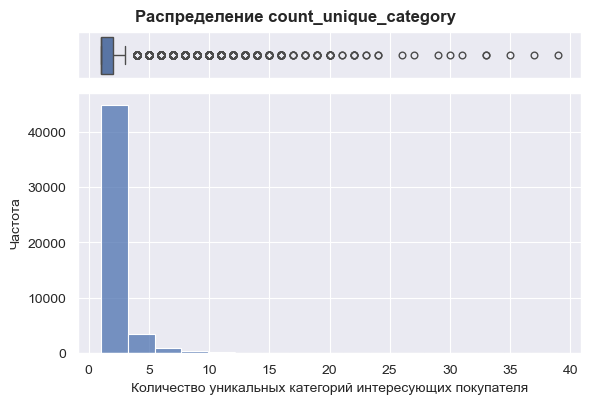

count      mean       std  min  25%  50%  75%   max
count_unique_category  49849.0  1.879917  1.612404  1.0  1.0  1.0  2.0  39.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                6086.396143
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [116]:
analyzis_quantity(data['count_unique_category'], 
                  x_label='Количество уникальных категорий интересующих покупателя')

Мы наблюдаем в значениях очень большой хвост, а максимальное значение больше значения `Q3` в 20 раз.

In [117]:
# Преобразование признака
data['count_unique_category_log'] = np.log1p(data['count_unique_category'])

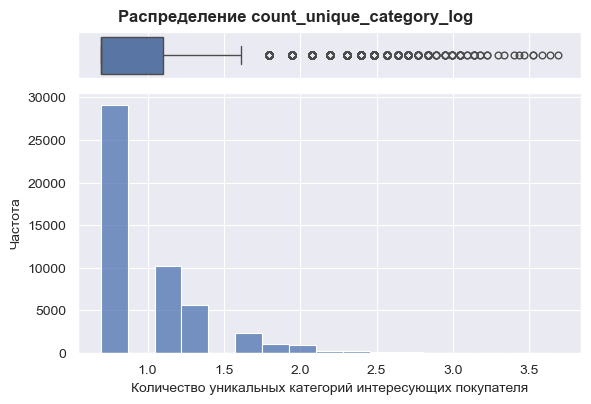

count      mean       std       min       25%  \
count_unique_category_log  49849.0  0.966849  0.385541  0.693147  0.693147   

                                50%       75%       max  
count_unique_category_log  0.693147  1.098612  3.688879

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                5364.665218
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [118]:
analyzis_quantity(data['count_unique_category_log'], 
                  x_label='Количество уникальных категорий интересующих покупателя')

In [119]:
# Анализ средних значений
display(data.groupby('target')['count_unique_category_log'].median().to_frame())
display(data.groupby('target')['count_unique_category_log'].mean().to_frame())

count_unique_category_log
target                           
0                        0.693147
1                        1.098612

count_unique_category_log
target                           
0                        0.962857
1                        1.169909

Мы сократили дистанцию между максимальным значением и `Q3`. Для дальнейшего анализа будем использовать этот признак.

Признак `count_unique_category` имеет положительно скошенное распределение с длинным хвостом. Для снижения влияния выбросов значения обработаны с помощью логарифмирования признака.

**Статистическое описание:**

`count_unique_category`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 2;
- **Max** — 39.

`count_unique_category_log`:

- **Min** — 0.693; 
- **Q1** — 0.693;
- **Median** — 0.693;
- **Q3** — 1.099;
- **Max** — 3.689.

#### Признак "total_amount":

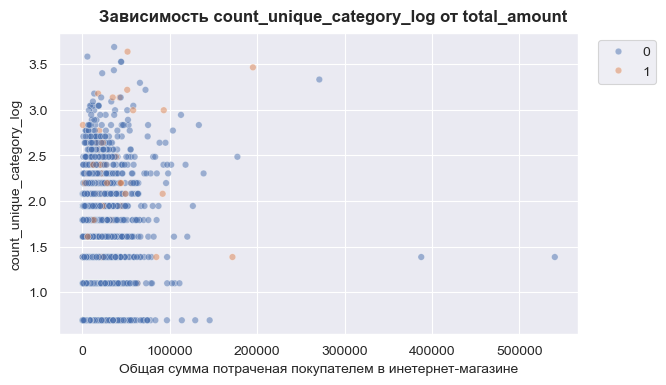

count         mean          std  min     25%     50%     75%  \
total_amount  49849.0  4865.584264  7351.467229  1.0  1499.0  2969.0  5698.0   

                   max  
total_amount  540408.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                5663.310275
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [120]:
analyzis_quantity(data['total_amount'], 
                  x_label='Общая сумма потраченая покупателем в инетернет-магазине', 
                  target=data['count_unique_category_log'], 
                  system=True, 
                  hue=data['target'])

В значениях присутствуют сильные выбросы, так как они сильно оторваны от остальных значений, в данному случае будет логичнее использовать компрессию значений и просто уменьшить значения выбросов, тем самым снизив их влияние.

In [121]:
# Обработка выбросов с помощью компрессии
data['total_amount_comp'] = compress(data['total_amount'], 
                                     threshold=150000, 
                                     coef=0.5, dry=0.1)

In [122]:
analyzis_quantity(data['total_amount_comp'], 
                  x_label='Общая сумма потраченая покупателем в инетернет-магазине', 
                  target=data['count_unique_category_log'], 
                  system=True, 
                  hue=data['target'])

count         mean          std  min     25%     50%  \
total_amount_comp  49849.0  4850.402744  6718.292663  1.0  1499.0  2969.0   

                      75%            max  
total_amount_comp  5698.0  189603.143738

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                5194.930224
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [123]:
# Анализ средних значений
display(data.groupby('target')['total_amount_comp'].median().to_frame())
display(data.groupby('target')['total_amount_comp'].mean().to_frame())

total_amount_comp
target                   
0                  2938.0
1                  3796.0

total_amount_comp
target                   
0             4812.877190
1             6759.403063

Признак `total_amount` имеет положительно скошенное распределение, сильные выбросы обработали с помощью компрессии, при этом сохранив структуру данных. 

Покупатели класса `1` в среднем тратят больше, но общая сумма потраченная в интернет-магазине обычно меньше 50000.

**Описательная статистика:**

`total_amount`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2969;
- **Q3** — 5698;
- **Max** — 540408.

`total_amount_comp`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2969;
- **Q3** — 5698;
- **Max** — 189603.14.

#### Признак "median_daily_quantity":

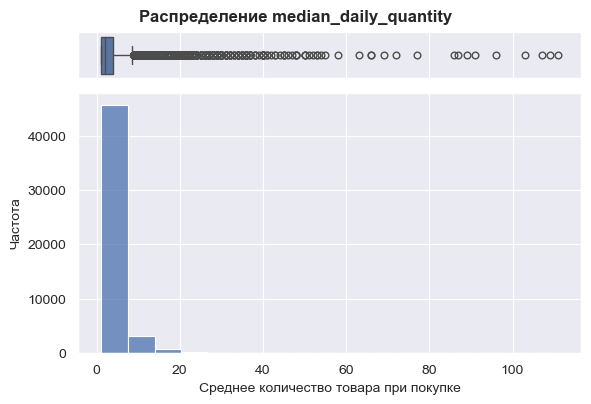

count      mean       std  min  25%  50%  75%    max
median_daily_quantity  49849.0  3.310096  3.768822  1.0  1.0  2.0  4.0  111.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                5102.121866
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [124]:
analyzis_quantity(data['median_daily_quantity'], 
                  x_label='Среднее количество товара при покупке', 
                  target=data['count_unique_category_log'], 
                  system=True, 
                  hue=data['target'])

В данном признаке так же есть выбросы, обработаем их.

In [125]:
# Обработка выбросов
data['median_daily_quantity_comp'] = compress(data['median_daily_quantity'],
                                              threshold=60, coef=0.5, dry=0.35)
data['median_daily_quantity_comp'] = compress(data['median_daily_quantity_comp'],
                                              threshold=40, coef=0.5, dry=0.3)

In [126]:
analyzis_quantity(data['median_daily_quantity_comp'], 
                  x_label='Среднее количество товара при покупке', 
                  target=data['count_unique_category_log'], 
                  system=True, 
                  hue=data['target'])

count      mean       std  min  25%  50%  75%  \
median_daily_quantity_comp  49849.0  3.298454  3.557705  1.0  1.0  2.0  4.0   

                                  max  
median_daily_quantity_comp  57.310587

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                4873.662214
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [127]:
# Анализ средних значений
display(data.groupby('target')['median_daily_quantity_comp'].median().to_frame())
display(data.groupby('target')['median_daily_quantity_comp'].mean().to_frame())

median_daily_quantity_comp
target                            
0                              2.0
1                              2.5

median_daily_quantity_comp
target                            
0                         3.287435
1                         3.859001

Признак `median_daily_quantity` имеет положительно скошенное распределение, выбросы обработали с помощью компрессии. 

Покупатели класса `1` в среднем покупают больше единиц товара за одну покупку, но обычно не превышает 15 единиц.

**Описательная статистика:**

`median_daily_quantity`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 2;
- **Q3** — 4;
- **Max** — 111.

`median_daily_quantity_comp`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 2;
- **Q3** — 4;
- **Max** — 57.3.

#### Признак "purchase_count_last_90d":

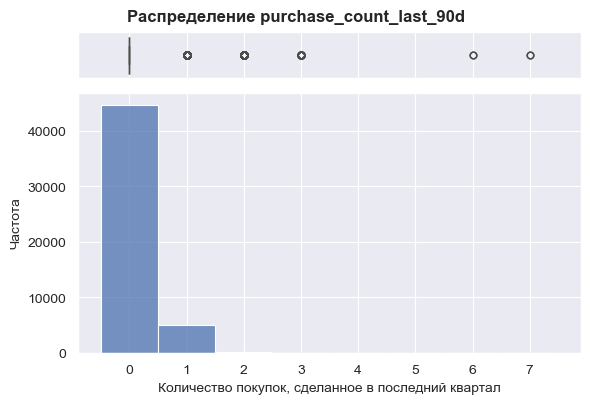

count      mean       std  min  25%  50%  75%  max
purchase_count_last_90d  49849.0  0.108748  0.330699  0.0  0.0  0.0  0.0  7.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               15785.224591
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [128]:
analyzis_quantity(data['purchase_count_last_90d'], 
                  x_label='Количество покупок, сделанное в последний квартал', 
                  target=data['count_unique_category_log'], 
                  system=True, discrete=True,
                  hue=data['target'])

Признак `purchase_count_last_90d` имеет положительно скошенное распределение, в данном случае обабатывать выбросы не вижу необходимости.

Замечено, что пользователи класса `1` которые не делали покупок в последнем квартале интересуются гораздо большим количество уникальных категорий. На `scatterplot` они локализуются в левом верхнем углу.

**Описательная статистика:**

`purchase_count_last_90d`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0;
- **Max** — 7.

#### Признак "avg_purchase_in_past":

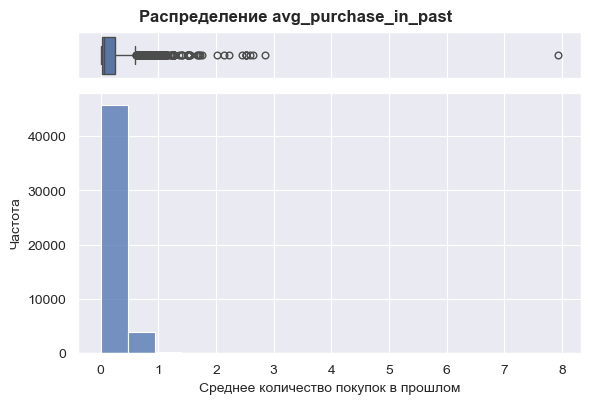

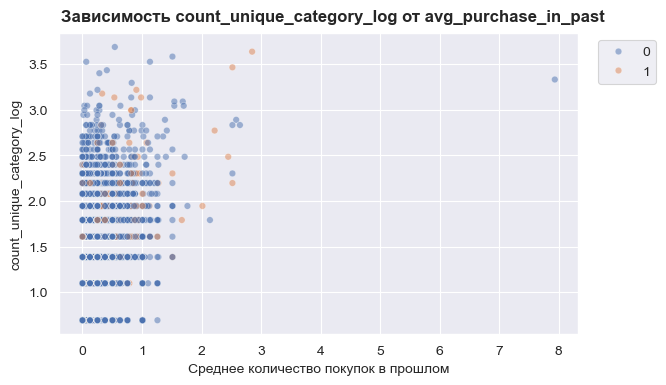

count      mean       std  min       25%       50%  \
avg_purchase_in_past  49849.0  0.130888  0.169691  0.0  0.015748  0.062992   

                           75%       max  
avg_purchase_in_past  0.251969  7.937008

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                3995.698455
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [129]:
analyzis_quantity(data['avg_purchase_in_past'], 
                  x_label='Среднее количество покупок в прошлом', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Обаботаем сильный выброс с помощью компрессии.

In [130]:
data['avg_purchase_in_past_comp'] = compress(data['avg_purchase_in_past'], threshold=3, method='log', coef=0)
data['avg_purchase_in_past_comp'] = compress(data['avg_purchase_in_past_comp'], 
                                             threshold=1.5, coef=0.5, dry=0.3)

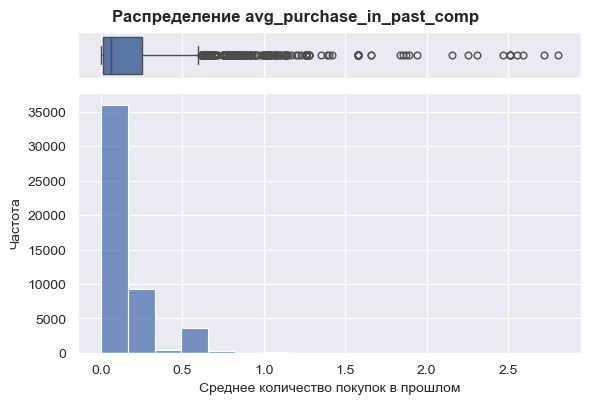

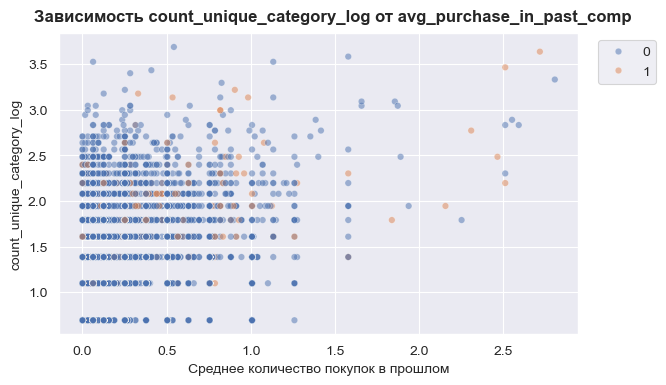

count      mean       std  min       25%  \
avg_purchase_in_past_comp  49849.0  0.130826  0.166849  0.0  0.015748   

                                50%       75%       max  
avg_purchase_in_past_comp  0.062992  0.251969  2.807321

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                3992.559394
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [131]:
analyzis_quantity(data['avg_purchase_in_past_comp'], 
                  x_label='Среднее количество покупок в прошлом', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

In [132]:
# Анализ средних значений
display(data.groupby('target')['avg_purchase_in_past_comp'].median().to_frame())
display(data.groupby('target')['avg_purchase_in_past_comp'].mean().to_frame())

avg_purchase_in_past_comp
target                           
0                        0.062992
1                        0.110236

avg_purchase_in_past_comp
target                           
0                        0.129336
1                        0.206592

Признак `avg_purchase_in_past` имеет положительно скошенное распределение, выбросы были обработаны с помощью компрессии значений.

**Статистическое описание:**

`avg_purchase_in_past`:

- **Min** — 0.0; 
- **Q1** — 0.02;
- **Median** — 0.06;
- **Q3** — 0.25;
- **Max** — 7.94.

`avg_purchase_in_past_comp`:

- **Min** — 0.0; 
- **Q1** — 0.02;
- **Median** — 0.06;
- **Q3** — 0.25;
- **Max** — 2.8.

#### Признак "trend_purchase":

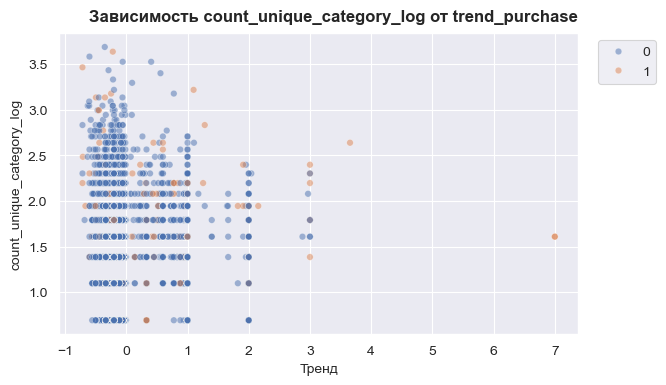

count      mean       std       min       25%       50%  \
trend_purchase  49849.0  0.005486  0.363963 -0.715884 -0.201258 -0.059259   

                     75%  max  
trend_purchase -0.015504  7.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                7828.457542
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [133]:
analyzis_quantity(data['trend_purchase'], 
                  x_label='Тренд', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Обработаем выбросы с помощью компрессии.

In [134]:
data['trend_purchase_comp'] = compress(data['trend_purchase'], threshold=1, 
                                       coef=0.5)

In [135]:
analyzis_quantity(data['trend_purchase_comp'], 
                  x_label='Тренд', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

count      mean       std       min       25%  \
trend_purchase_comp  49849.0  0.005251  0.360977 -0.715884 -0.201258   

                          50%       75%      max  
trend_purchase_comp -0.059259 -0.015504  3.44949

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                7830.017795
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [136]:
# Анализ средних значений
display(data.groupby('target')['trend_purchase_comp'].median().to_frame())
display(data.groupby('target')['trend_purchase_comp'].mean().to_frame())

trend_purchase_comp
target                     
0                 -0.059259
1                 -0.059259

trend_purchase_comp
target                     
0                  0.002123
1                  0.164364

Признак `trend_purchase` имеет бимодальное распроделением с основным пиком на значении `-0.59` и с небольшим пиком на значении `1`. Выбросы обработаны с помощью компрессии пиковых значений. 

**Описательная статистика:**

`trend_purchase`:

- **Min** — -0.72; 
- **Q1** — -0.2;
- **Median** — -0.06;
- **Q3** — -0.02;
- **Max** — 7.

`trend_purchase_comp`:

- **Min** — -0.72; 
- **Q1** — -0.2;
- **Median** — -0.06;
- **Q3** — -0.02;
- **Max** — 3.4.

#### Признак "total_purchase":

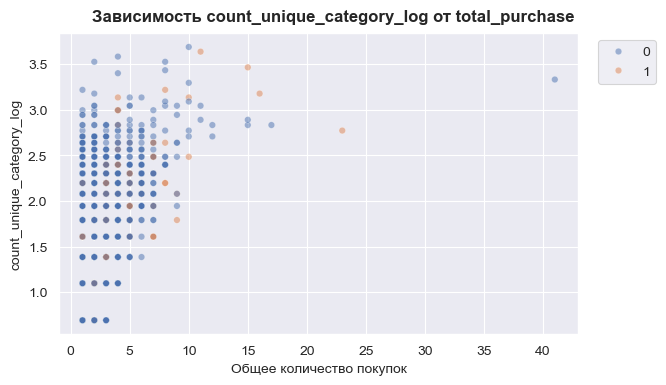

count      mean       std  min  25%  50%  75%   max
total_purchase  49849.0  1.207808  0.665728  1.0  1.0  1.0  1.0  41.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               12652.941054
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [137]:
analyzis_quantity(data['total_purchase'], 
                  x_label='Общее количество покупок', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Обработаем сильные выбросы с помощью компрессии.

In [138]:
data['total_purchase_comp'] = compress(data['total_purchase'], threshold=12, 
                                       coef=0.5, dry=0.2)

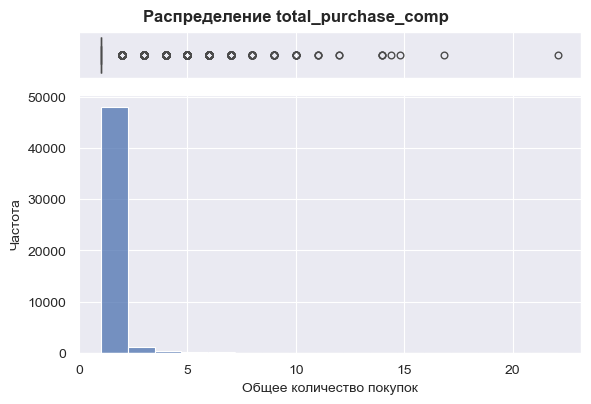

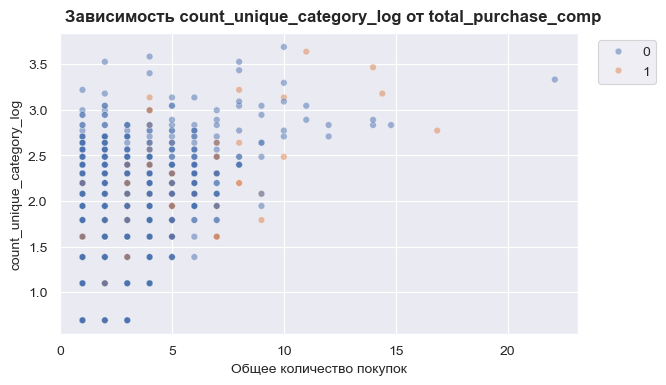

count      mean       std  min  25%  50%  75%  \
total_purchase_comp  49849.0  1.207168  0.641679  1.0  1.0  1.0  1.0   

                           max  
total_purchase_comp  22.108132

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               12735.113813
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [139]:
analyzis_quantity(data['total_purchase_comp'], 
                  x_label='Общее количество покупок', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `total_purchase` имеет положительно скошенное распределение, сильные выбросы обработаны с помощью компрессии.

**Статистическое описание:**

`total_purchase`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 41.

`total_purchase_comp`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 22.11.

#### Признак "avg_receipt":

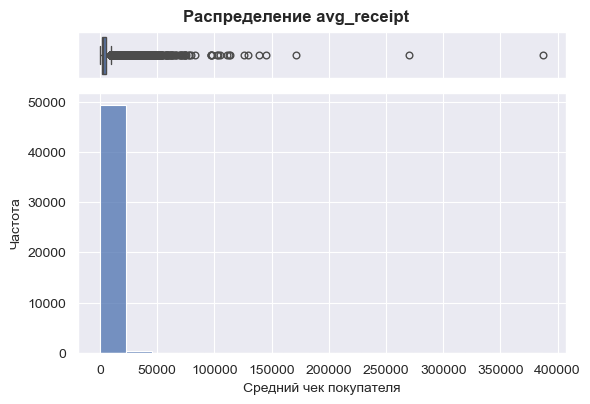

count         mean          std  min     25%     50%     75%  \
avg_receipt  49849.0  4043.236796  5549.149961  1.0  1499.0  2598.0  4898.0   

                  max  
avg_receipt  387583.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                 5122.39686
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [140]:
analyzis_quantity(data['avg_receipt'], 
                  x_label='Средний чек покупателя', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Применим компрессию для снижения влияния выбросов.

In [141]:
data['avg_receipt_comp'] = compress(data['avg_receipt'], threshold=80000, 
                                    coef=0.5, dry=0.2)
data['avg_receipt_comp'] = compress(data['avg_receipt_comp'], threshold=100000, 
                                    coef=0.5, dry=0.05)

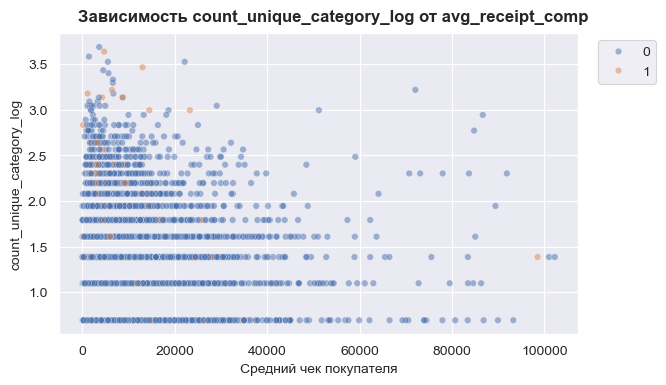

count         mean          std  min     25%     50%  \
avg_receipt_comp  49849.0  4025.330055  4995.490566  1.0  1499.0  2598.0   

                     75%            max  
avg_receipt_comp  4898.0  102292.614051

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                4567.978703
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [142]:
analyzis_quantity(data['avg_receipt_comp'], 
                  x_label='Средний чек покупателя', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `avg_receipt` имеет положительно скошенное распределение, сильные выбросы обработаны с помощью компрессии.

Пользователи класса `1` на `scatterplot` в основном расположены в левом верхнем углу, то есть эти покупатели в основном делают мелкие покупки.

**Статистическое описание:**

`avg_receipt`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2598;
- **Q3** — 4898;
- **Max** — 387583.

`avg_receipt_comp`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2598;
- **Q3** — 4898;
- **Max** — 1022929.61.

#### Признак "share_sale":

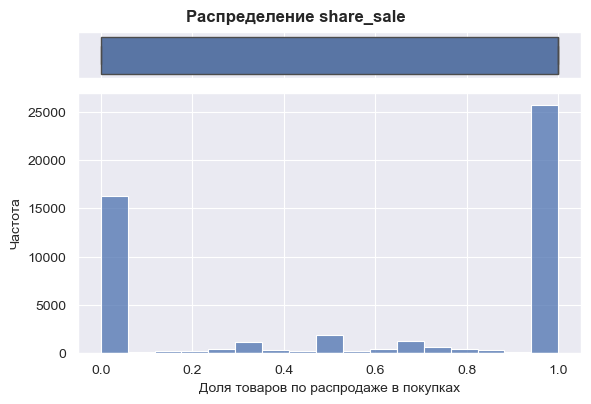

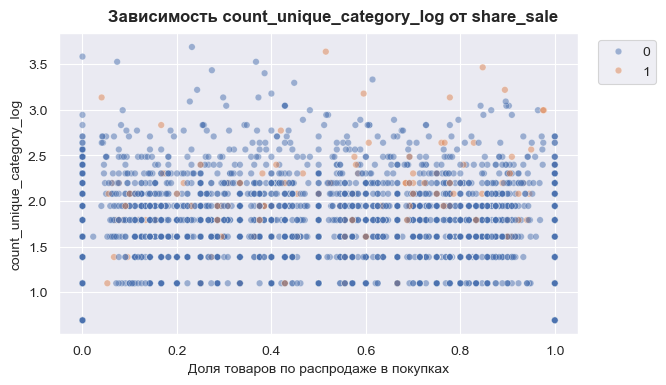

count      mean       std  min  25%  50%  75%  max
share_sale  49849.0  0.597331  0.455215  0.0  0.0  1.0  1.0  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                6542.238361
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [143]:
analyzis_quantity(data['share_sale'], 
                  x_label='Доля товаров по распродаже в покупках', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `share_sale` имеет пятимодальное распределение, пики расположены на значениях `0`, `0.3`, `0.5`, `0.7` и `1`.

Замечено, что клиенты класса `1` покупают товар, как по скидке, так и за полную ценную, в крайних случаях этот класс не наблюдается.

**Статистическое описание:**

`share_sale`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 1.

#### Признак "email_open_prob":

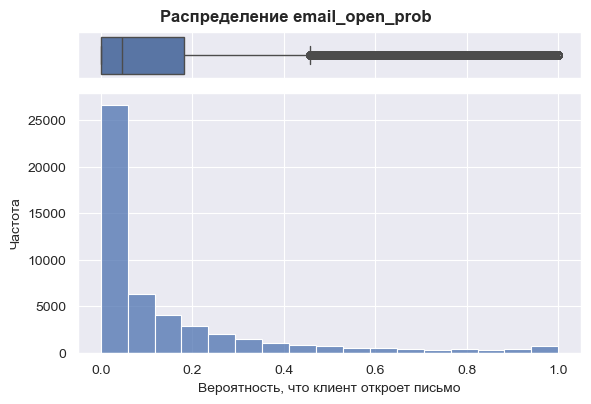

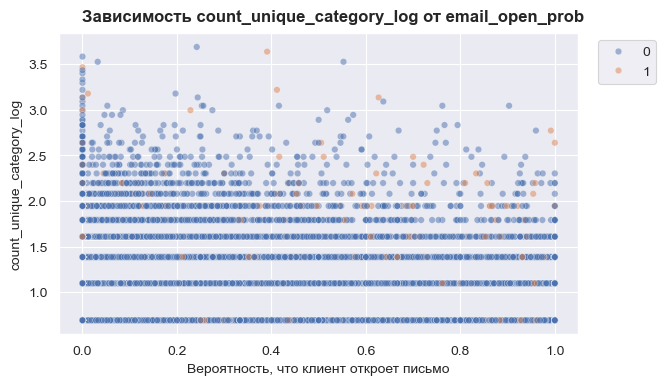

count      mean       std  min  25%       50%       75%  \
email_open_prob  49849.0  0.141892  0.220945  0.0  0.0  0.046512  0.182692   

                 max  
email_open_prob  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                5492.413287
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [144]:
analyzis_quantity(data['email_open_prob'], 
                  x_label='Вероятность, что клиент откроет письмо', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `email_open_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

**75%** значений находятся на `scatterplot` в левой части графика, в наибольшем скоплении, а именно левый нижний угол не наблюдаются клиенты класса `1`, что может модели существенно помочь в классификации покупателей.

**Статистическое описание:**

`email_open_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.05;
- **Q3** — 0.18;
- **Max** — 1.

#### Признак "email_click_prob":

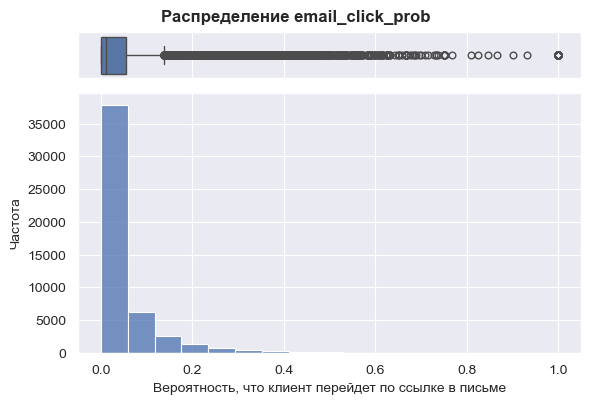

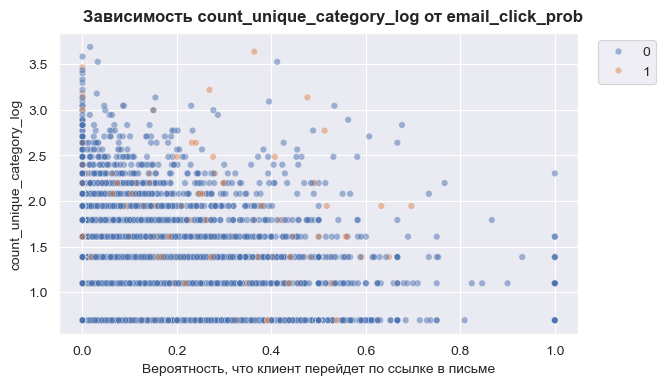

count      mean      std  min  25%       50%       75%  \
email_click_prob  49849.0  0.045346  0.08409  0.0  0.0  0.010753  0.055556   

                  max  
email_click_prob  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                6224.888857
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [145]:
analyzis_quantity(data['email_click_prob'], 
                  x_label='Вероятность, что клиент перейдет по ссылке в письме', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `email_click_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

**75%** значений находятся на `scatterplot` в левой части графика, в наибольшем скоплении, а именно левый нижний угол не наблюдаются клиенты класса `1`, что может модели существенно помочь в классификации покупателей.

**Статистическое описание:**

`email_click_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.01;
- **Q3** — 0.06;
- **Max** — 1.

#### Признак "email_purchase_prob":

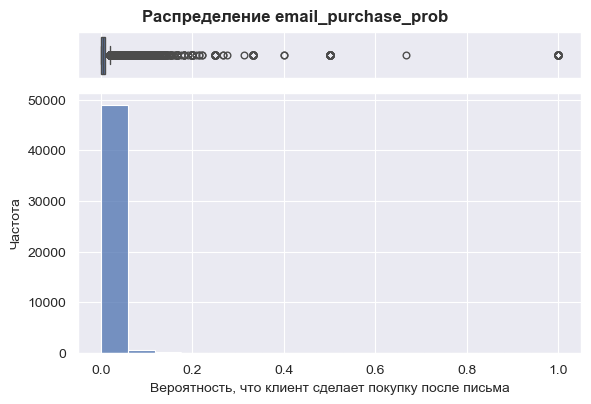

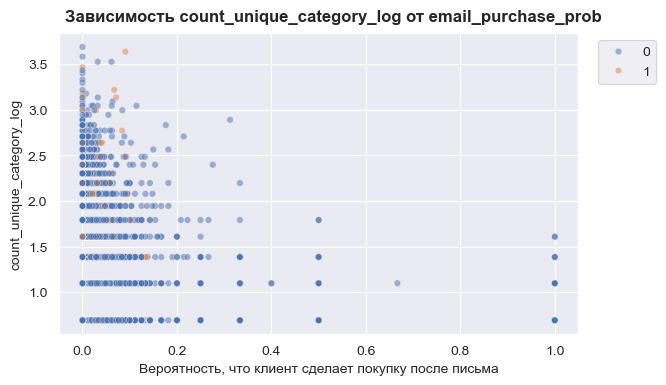

count      mean       std  min  25%       50%  \
email_purchase_prob  49849.0  0.008621  0.031155  0.0  0.0  0.004149   

                          75%  max  
email_purchase_prob  0.008475  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               10444.568278
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [146]:
analyzis_quantity(data['email_purchase_prob'], 
                  x_label='Вероятность, что клиент сделает покупку после письма', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `email_purchase_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

На граффике `scatterplot` мы видим, что клиенты класса `1` с меньшей вероятностью покупают после писем от интернет-магазина, то есть они совершают покупки более осознанно.

**Статистическое описание:**

`email_purchase_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.004;
- **Q3** — 0.008;
- **Max** — 1.

#### Признак "email_complain_prob":

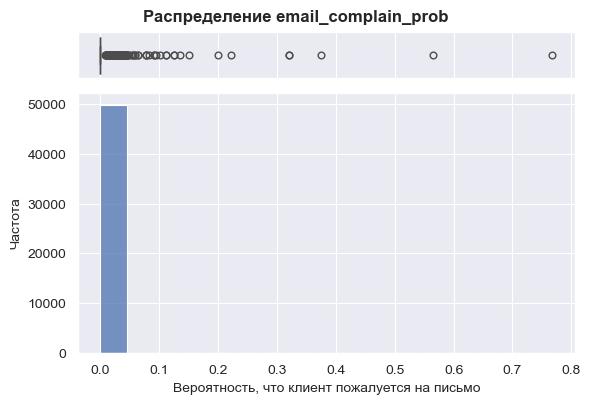

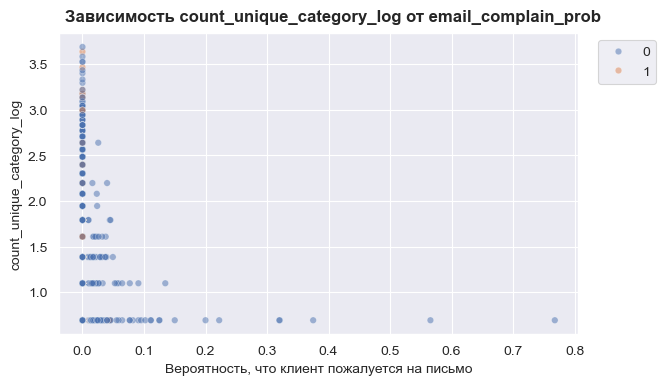

count      mean       std  min  25%  50%  75%       max
email_complain_prob  49849.0  0.000189  0.005737  0.0  0.0  0.0  0.0  0.767857

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                18934.36504
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [147]:
analyzis_quantity(data['email_complain_prob'], 
                  x_label='Вероятность, что клиент пожалуется на письмо', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `email_complain_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

По графикам видно, что клиенты класса `1` никогда не жалуются на рассылку по `email`.

**Статистическое описание:**

`email_complain_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0;
- **Max** — 0.77.

#### Признак "push_open_prob":

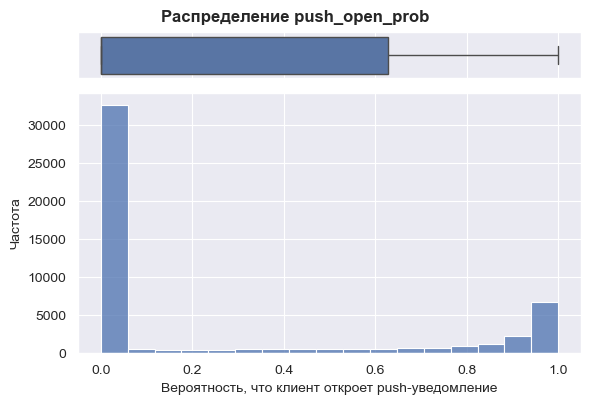

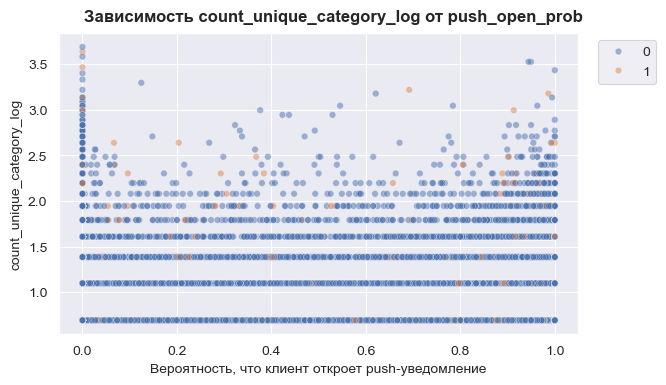

count     mean       std  min  25%  50%       75%  max
push_open_prob  49849.0  0.26122  0.393983  0.0  0.0  0.0  0.628019  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                                8442.368984
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [148]:
analyzis_quantity(data['push_open_prob'], 
                  x_label='Вероятность, что клиент откроет push-уведомление', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `push_open_prob` имеет бимодальное распределение с пиками на значениях `0` и `1`.

**Статистическое описание:**

`push_open_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.63;
- **Max** — 0.1.

#### Признак "push_click_prob":

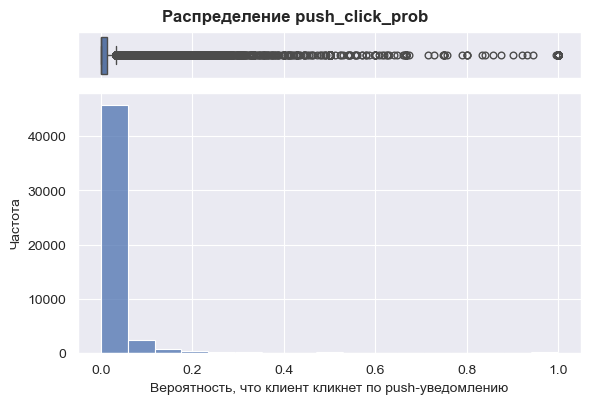

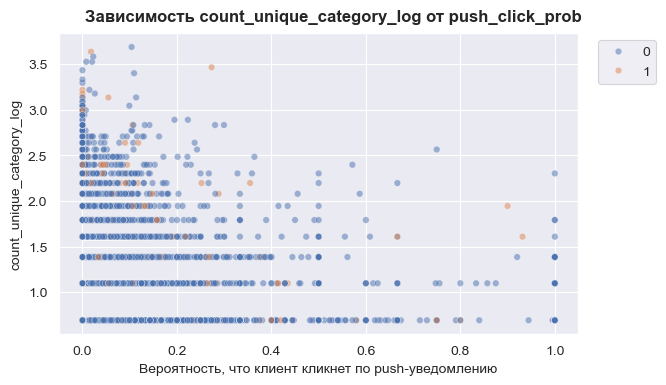

count      mean       std  min  25%  50%       75%  max
push_click_prob  49849.0  0.018988  0.065431  0.0  0.0  0.0  0.013514  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               10959.284114
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [149]:
analyzis_quantity(data['push_click_prob'], 
                  x_label='Вероятность, что клиент кликнет по push-уведомлению', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `push_click_prob` имеет положительно скошенное распределение, выбросы оставляем без изменений.

На графике `scatterplot` так же не наблюдаются в нижнем левом углу клиентов класса `1`.

**Статистическое описание:**

`push_click_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.014;
- **Max** — 1.

#### Признак "push_purchase_prob":

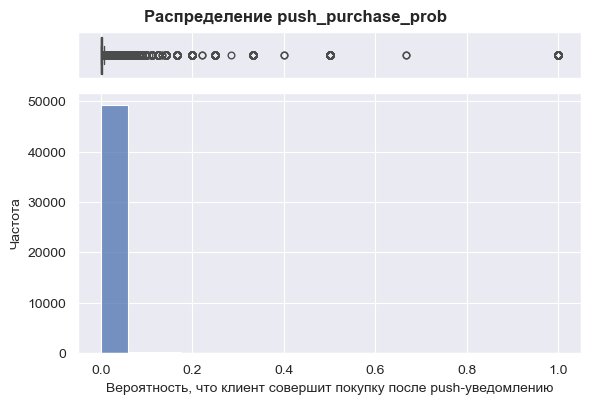

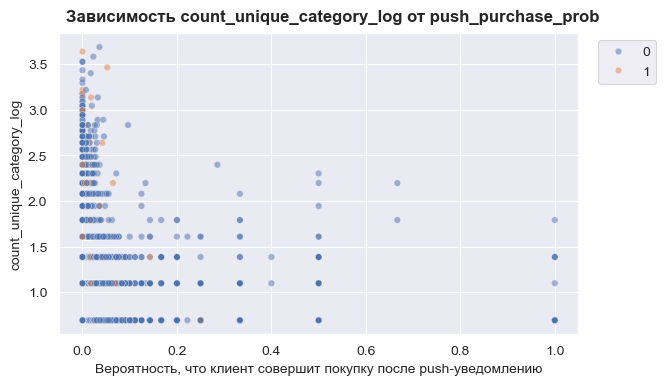

count      mean       std  min  25%  50%       75%  max
push_purchase_prob  49849.0  0.005053  0.039227  0.0  0.0  0.0  0.003311  1.0

Тест на нормальность распределения (порог=0.05):
                                                                      
Статистика:                                               15572.773958
Критические значения:              [0.576, 0.656, 0.787, 0.918, 1.092]
Распределение                                   Не является нормальным

In [150]:
analyzis_quantity(data['push_purchase_prob'], 
                  x_label='Вероятность, что клиент совершит покупку после push-уведомлению', 
                  target=data['count_unique_category_log'], 
                  system=True,
                  hue=data['target'])

Признак `push_purchase_prob` имеет положительно скошенное распределение, выбросы оставляем без изменений.

В ситуации, как и с каналом `email`, клиенты класса `1` в основном реже совершают покупку после push-уведомления.

**Статистическое описание:**

`push_purchase_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.003;
- **Max** — 1.

### Категориальные признаки:

#### Univariate AUC — оценка категориальных признаков:

Так как все категориальные признаки у нас бинарные, так же проведем их оценку на полезность для модели.

In [151]:
# Поиск наиболее полезного признака
auc = []
cols = []
for col in cat_col:
    score = roc_auc_score(data['target'], data[col])
    cols.append(col)
    auc.append(score)
auc_result = pd.DataFrame({'Признак': cols, 
                           'AUC': auc})
auc_result.sort_values(by='AUC', ascending=False)

Признак       AUC
2        is_newly_active  0.553631
1       email_subscribed  0.533661
3  receive_notifications  0.519450
0             email_spam  0.498226

По предварительной оценке наиболее полезным признаком являются те пользователи, которые совершили покупку впервые в последний квартал.

#### Признак "email_subscribed":

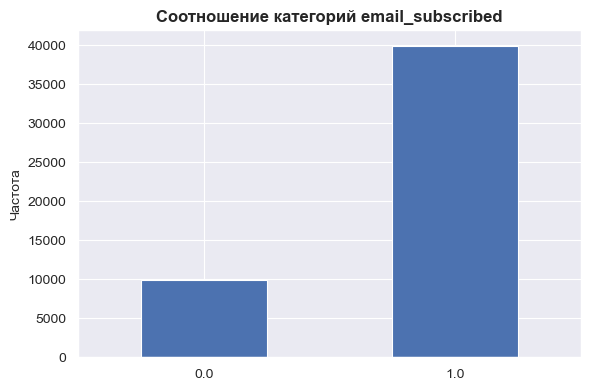

email_subscribed  count
0               0.0   9879
1               1.0  39970

target  email_subscribed
1       1          0.867846
0       0          0.800524

In [152]:
analyzis_category(data['email_subscribed'])
cat_groupby(data, col='email_subscribed', target='target')

Соотношение клиентов, которые подписаны на рассылку по `email` и нет, `4:1` соответственно.

Клиенты класса `1` чаще подписаны на рассылку интернет-магазина по каналу `email`.

#### Признак "receive_notifications":

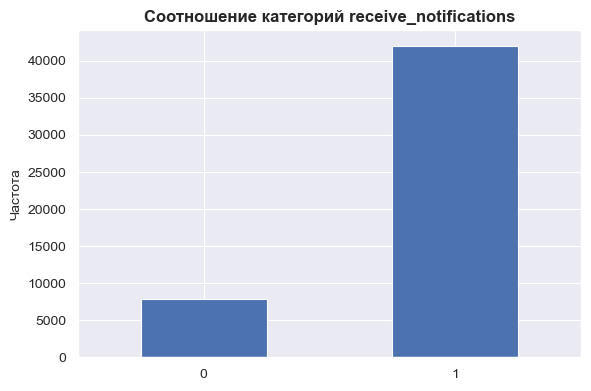

receive_notifications  count
0                      0   7867
1                      1  41982

target  receive_notifications
1       1               0.880333
0       0               0.841433

In [153]:
analyzis_category(data['receive_notifications'])
cat_groupby(data, col='receive_notifications', target='target')

Соотношение клиентов, которые получали сообщения от интернет-магазина и нет, `5:1` соответственно.

Клиенты класса `1` чаще получали сообщения от интернет-магазина.

#### Признак "is_newly_active":

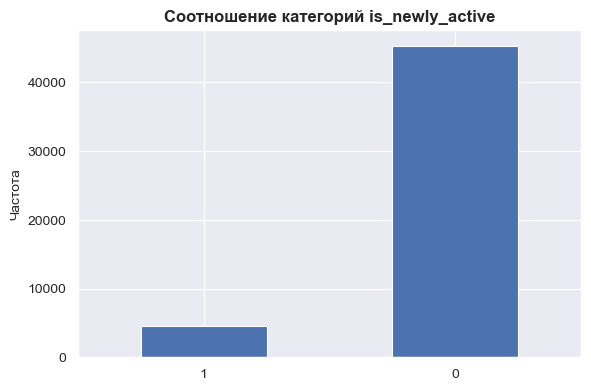

is_newly_active  count
0                1   4560
1                0  45289

target  is_newly_active
1       1         0.196670
0       0         0.089408

In [154]:
analyzis_category(data['is_newly_active'])
cat_groupby(data, col='is_newly_active', target='target')

Соотношение клиентов, которые впервые совершили покупку в последнем квартале и нет, `1:9` соотвтетственно.

Среди клиентов класса `1` в 2 раза больше тех, кто совершил покупку впервые в последний квартал.

#### Признак "email_spam":

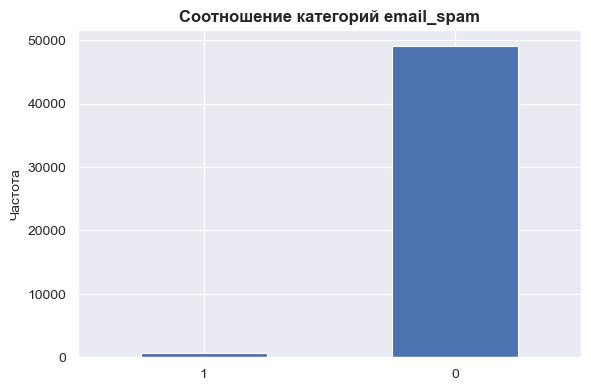

email_spam  count
0           1    744
1           0  49105

target  email_spam
0       0    0.014993
1       1    0.011446

In [155]:
analyzis_category(data['email_spam'])
cat_groupby(data, col='email_spam', target='target')

Приблизительно каждый `100й` клиент поместил рассылку по каналу `email` в спам.

Среди клиентов `1` и `0` классов, тех, кто поместил рассылку в спам примерно одинаково.

### Вывод:

**Количественные признаки:**

Признак `count_unique_category` имеет положительно скошенное распределение с длинным хвостом. Для снижения влияния выбросов значения обработаны с помощью логарифмирования признака.

**Статистическое описание:**

`count_unique_category`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 2;
- **Max** — 39.

`count_unique_category_log`:

- **Min** — 0.693; 
- **Q1** — 0.693;
- **Median** — 0.693;
- **Q3** — 1.099;
- **Max** — 3.689.


Признак `total_amount` имеет положительно скошенное распределение, сильные выбросы обработали с помощью компрессии, при этом сохранив структуру данных. 

Покупатели класса `1` в среднем тратят больше, но общая сумма потраченная в интернет-магазине обычно меньше 50000.

**Описательная статистика:**

`total_amount`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2969;
- **Q3** — 5698;
- **Max** — 540408.

`total_amount_comp`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2969;
- **Q3** — 5698;
- **Max** — 189603.14.


Признак `median_daily_quantity` имеет положительно скошенное распределение, выбросы обработали с помощью компрессии. 

Покупатели класса `1` в среднем покупают больше единиц товара за одну покупку, но обычно не превышает 15 единиц.

**Описательная статистика:**

`median_daily_quantity`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 2;
- **Q3** — 4;
- **Max** — 111.

`median_daily_quantity_comp`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 2;
- **Q3** — 4;
- **Max** — 57.3.


Признак `purchase_count_last_90d` имеет положительно скошенное распределение, в данном случае обабатывать выбросы не вижу необходимости.

Замечено, что пользователи класса `1` которые не делали покупок в последнем квартале интересуются гораздо большим количество уникальных категорий. На `scatterplot` они локализуются в левом верхнем углу.

**Описательная статистика:**

`purchase_count_last_90d`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0;
- **Max** — 7.


Признак `avg_purchase_in_past` имеет положительно скошенное распределение, выбросы были обработаны с помощью компрессии значений.

**Статистическое описание:**

`avg_purchase_in_past`:

- **Min** — 0.0; 
- **Q1** — 0.02;
- **Median** — 0.06;
- **Q3** — 0.25;
- **Max** — 7.94.

`avg_purchase_in_past_comp`:

- **Min** — 0.0; 
- **Q1** — 0.02;
- **Median** — 0.06;
- **Q3** — 0.25;
- **Max** — 2.8.


Признак `trend_purchase` имеет бимодальное распроделением с основным пиком на значении `-0.59` и с небольшим пиком на значении `1`. Выбросы обработаны с помощью компрессии пиковых значений. 

**Описательная статистика:**

`trend_purchase`:

- **Min** — -0.72; 
- **Q1** — -0.2;
- **Median** — -0.06;
- **Q3** — -0.02;
- **Max** — 7.

`trend_purchase_comp`:

- **Min** — -0.72; 
- **Q1** — -0.2;
- **Median** — -0.06;
- **Q3** — -0.02;
- **Max** — 3.4.


Признак `total_purchase` имеет положительно скошенное распределение, сильные выбросы обработаны с помощью компрессии.

**Статистическое описание:**

`total_purchase`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 41.

`total_purchase_comp`:

- **Min** — 1; 
- **Q1** — 1;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 22.11.


Признак `avg_receipt` имеет положительно скошенное распределение, сильные выбросы обработаны с помощью компрессии.

Пользователи класса `1` на `scatterplot` в основном расположены в левом верхнем углу, то есть эти покупатели в основном делают мелкие покупки.

**Статистическое описание:**

`avg_receipt`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2598;
- **Q3** — 4898;
- **Max** — 387583.

`avg_receipt_comp`:

- **Min** — 1; 
- **Q1** — 1499;
- **Median** — 2598;
- **Q3** — 4898;
- **Max** — 1022929.61.


Признак `share_sale` имеет пятимодальное распределение, пики расположены на значениях `0`, `0.3`, `0.5`, `0.7` и `1`.

Замечено, что клиенты класса `1` покупают товар, как по скидке, так и за полную ценную, в крайних случаях этот класс не наблюдается.

**Статистическое описание:**

`share_sale`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 1;
- **Q3** — 1;
- **Max** — 1.


Признак `email_open_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

**75%** значений находятся на `scatterplot` в левой части графика, в наибольшем скоплении, а именно левый нижний угол не наблюдаются клиенты класса `1`, что может модели существенно помочь в классификации покупателей.

**Статистическое описание:**

`email_open_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.05;
- **Q3** — 0.18;
- **Max** — 1.


Признак `email_click_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

**75%** значений находятся на `scatterplot` в левой части графика, в наибольшем скоплении, а именно левый нижний угол не наблюдаются клиенты класса `1`, что может модели существенно помочь в классификации покупателей.

**Статистическое описание:**

`email_click_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.01;
- **Q3** — 0.06;
- **Max** — 1.


Признак `email_purchase_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

На граффике `scatterplot` мы видим, что клиенты класса `1` с меньшей вероятностью покупают после писем от интернет-магазина, то есть они совершают покупки более осознанно.

**Статистическое описание:**

`email_purchase_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0.004;
- **Q3** — 0.008;
- **Max** — 1.


Признак `email_complain_prob` имеет положительно скошанное распределение, выбросы оставляем без изменений.

По графикам видно, что клиенты класса `1` никогда не жалуются на рассылку по `email`.

**Статистическое описание:**

`email_complain_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0;
- **Max** — 0.77.


Признак `push_open_prob` имеет бимодальное распределение с пиками на значениях `0` и `1`.

**Статистическое описание:**

`push_open_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.63;
- **Max** — 0.1.


Признак `push_click_prob` имеет положительно скошенное распределение, выбросы оставляем без изменений.

На графике `scatterplot` так же не наблюдаются в нижнем левом углу клиентов класса `1`.

**Статистическое описание:**

`push_click_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.014;
- **Max** — 1.


Признак `push_purchase_prob` имеет положительно скошенное распределение, выбросы оставляем без изменений.

В ситуации, как и с каналом `email`, клиенты класса `1` в основном реже совершают покупку после push-уведомления.

**Статистическое описание:**

`push_purchase_prob`:

- **Min** — 0; 
- **Q1** — 0;
- **Median** — 0;
- **Q3** — 0.003;
- **Max** — 1.


**Категориальные признаки:**

- Соотношение клиентов, которые подписаны на рассылку по `email` и нет, `4:1` соответственно. Клиенты класса `1` чаще подписаны на рассылку интернет-магазина по каналу `email`.


- Соотношение клиентов, которые получали сообщения от интернет-магазина и нет, `5:1` соответственно. Клиенты класса `1` чаще получали сообщения от интернет-магазина.


- Соотношение клиентов, которые впервые совершили покупку в последнем квартале и нет, `1:9` соотвтетственно. Среди клиентов класса `1` в 2 раза больше тех, кто совершил покупку впервые в последний квартал.


- Приблизительно каждый `100й` клиент поместил рассылку по каналу `email` в спам. Среди клиентов `1` и `0` классов, тех, кто поместил рассылку в спам примерно одинаково.


**Итог:**

Несмотря на изначальную слабую зависимость целевого признака и входных, после исследовательского анализа можем предположить, что в совокупности они могут хорошо охарактеризовать клиента класса `1`.

## Корреляционный анализ:

Далее мы будет использовать только преобразованные признаки, после выбора наилучшей модели мы оптимизируем набор признаков и проверим, какой из признаков лучше работает на результат, скомпрессированный или оригинальный.

Получим датафрейм для дальнейшей работы.

In [156]:
# Оставляем признаки необходимые для дальнейшей работы
raw_feature = ['total_amount', 'median_daily_quantity', 'avg_purchase_in_past', 
               'trend_purchase', 'total_purchase', 'avg_receipt', 
               'count_unique_category']

work_feature = list(set(data.columns) - set(raw_feature))

In [157]:
# Обновляем список количественных признаков
num_col = ['purchase_count_last_90d', 'share_sale', 'email_open_prob',
           'email_click_prob', 'email_purchase_prob', 'email_complain_prob',
           'push_open_prob', 'push_click_prob', 'push_purchase_prob', 
           'count_unique_category_log', 'total_amount_comp', 'median_daily_quantity_comp', 
           'avg_purchase_in_past_comp', 'trend_purchase_comp', 'total_purchase_comp', 
           'avg_receipt_comp']

### Матрица корреляции (метод Пирсона):

Проанализируем линейную зависимость между количественными признаками, для проверки наличия мультиколлинеарности между ними.

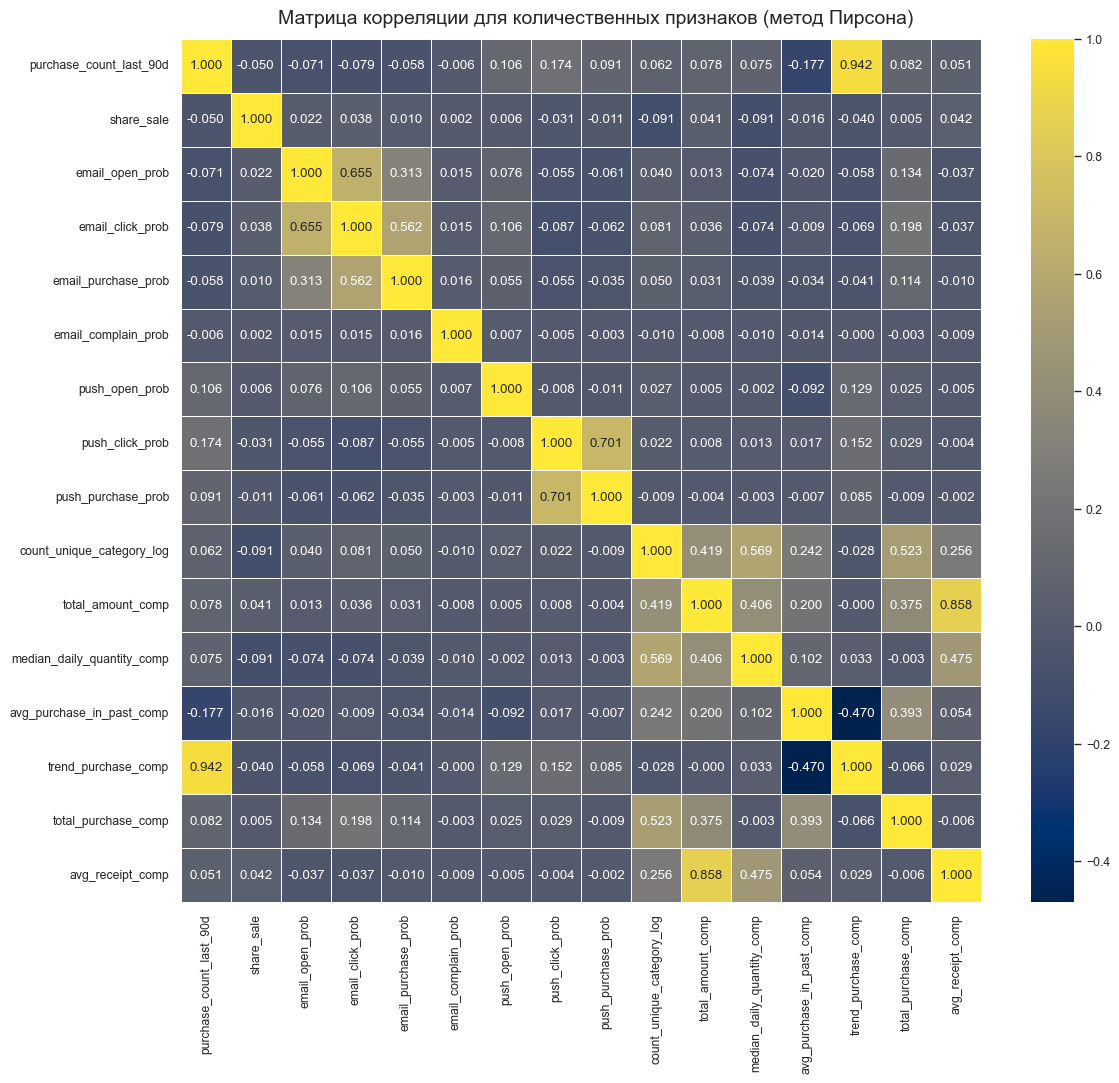

In [158]:
# Строим тепловую карту
f, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(data[num_col].corr(), annot=True, fmt='.3f', 
            linewidths=.5, cmap='cividis', ax=ax)

# Настройка заголовка и подписей
f.suptitle('Матрица корреляции для количественных признаков (метод Пирсона)', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Отображаем график
plt.tight_layout()
plt.show()

Наблюдаем сильную корреляцию между парами признаками `total_amount_comp` — `avg_receipt_comp` и `purchase_count_last_90d` — `trend_purchase_comp`.

Дополнительно построим таблицу с расчетом `VIF-фактора`.

#### VIF-фактор:

In [159]:
# Построения таблицы с расчетом VIF-фактора
vif_factor(data, num_col)

input attribute        vif
0      purchase_count_last_90d  52.214752
1                   share_sale   2.379309
2              email_open_prob   2.480157
3             email_click_prob   3.087959
4          email_purchase_prob   1.590126
5          email_complain_prob   1.001584
6               push_open_prob   1.459920
7              push_click_prob   2.200055
8           push_purchase_prob   2.010530
9    count_unique_category_log  14.908348
10           total_amount_comp   9.337828
11  median_daily_quantity_comp   4.003541
12   avg_purchase_in_past_comp  10.821879
13         trend_purchase_comp  58.268738
14         total_purchase_comp  12.688148
15            avg_receipt_comp   9.249455

Анализ `VIF-фактора` выявил еще несколько пар, между которыми возникает мультиколлинеарность, перечислим все пары:

- `purchase_count_last_90d` (52) — `trend_purchase_comp` (58);
- `avg_purchase_in_past_comp` (11) — `trend_purchase_comp` (58);
- `total_purchase_comp` (13) — `count_unique_category_log` (15);
- `total_amount_comp` (10) — `avg_receipt_comp` (10).

---

Пара: `total_amount_comp` (10) — `avg_receipt_comp` (10)

Исходя из того, что **более 75%** клиентов имеют только одну покупку за все время, признак среднего чека нам дает мало информации, он почти дублирует информацию из признака общей потраченной суммы на сайте, поэтому логичнее избавиться от одного из признаков, решение примем после анализа корреляции с целевым признаком, и оставим наболее коррелируемый.

---

Пара: `total_purchase_comp` (13) — `count_unique_category_log` (15)

В виду того, что анализ `Univariate AUC` говорит, что признак `count_unique_category_log` более полезен будет для модели, преобразуем признак `total_purchase_comp`.

---

Пара: `purchase_count_last_90d` (52) — `trend_purchase_comp` (58) и `avg_purchase_in_past_comp` (11) — `trend_purchase_comp` (58), преобразуем признак `trend_purchase_comp` в виду того, что он фигурирует в нескольких парах.

#### Преобразование признаков:

In [160]:
# Преобразование признака "total_purchase_comp"
data['total_purchase_comp^2'] = (data['total_purchase_comp'] + 1) ** 2

# Преобразование признака "total_purchase"
data['total_purchase^2'] = (data['total_purchase'] + 1) ** 2

In [161]:
# Преобразование признака "trend_purchase_comp" (3 степень для сохранения знака)
data['trend_purchase_comp^3'] = data['trend_purchase_comp'] ** 3

# Преобразование признака "trend_purchase" (3 степень для сохранения знака)
data['trend_purchase^3'] = data['trend_purchase'] ** 3

In [162]:
# Обновляем список количественных признаков
num_col = ['purchase_count_last_90d', 'share_sale', 'email_open_prob',
           'email_click_prob', 'email_purchase_prob', 'email_complain_prob',
           'email_spam', 'email_subscribed', 'push_open_prob', 'push_click_prob',
           'push_purchase_prob', 'count_unique_category_log', 'total_amount_comp',
           'median_daily_quantity_comp', 'avg_purchase_in_past_comp', 'trend_purchase_comp^3',
           'total_purchase_comp^2', 'avg_receipt_comp']

In [163]:
# Построения таблицы с расчетом VIF-фактора
vif_factor(data, num_col)

input attribute        vif
0      purchase_count_last_90d   2.669903
1                   share_sale   2.372654
2              email_open_prob   2.516912
3             email_click_prob   3.086501
4          email_purchase_prob   1.590413
5          email_complain_prob   1.001600
6                   email_spam   1.018424
7             email_subscribed   4.614232
8               push_open_prob   1.572260
9              push_click_prob   2.242688
10          push_purchase_prob   2.012988
11   count_unique_category_log   9.707803
12           total_amount_comp  10.260606
13  median_daily_quantity_comp   3.644880
14   avg_purchase_in_past_comp   2.031593
15       trend_purchase_comp^3   2.369206
16       total_purchase_comp^2   3.934405
17            avg_receipt_comp  10.153949

Количество уникальных категорий сильно связан так же с парой `total_amount_comp` — `avg_receipt_comp`, для продвижения дальше проанализируем матрицу `Phik`.

In [164]:
# Обновляем списки
raw_feature = ['total_amount', 'median_daily_quantity', 'avg_purchase_in_past', 
               'trend_purchase^3', 'total_purchase^2', 'avg_receipt', 
               'count_unique_category']
drop_feature = ['trend_purchase', 'total_purchase', 'trend_purchase_comp', 'total_purchase_comp']

work_feature = list(set(data.columns) - set(raw_feature) - set(drop_feature))

### Матрица Phik:

In [165]:
# Список непрерывных признаков
interval_cols = ['email_purchase_prob', 'email_click_prob', 'push_purchase_prob',
                 'avg_purchase_in_past_comp', 'push_click_prob', 'share_sale',
                 'push_open_prob', 'total_amount_comp', 'median_daily_quantity_comp',
                 'email_complain_prob', 'email_open_prob', 'trend_purchase_comp^3',
                 'avg_receipt_comp']

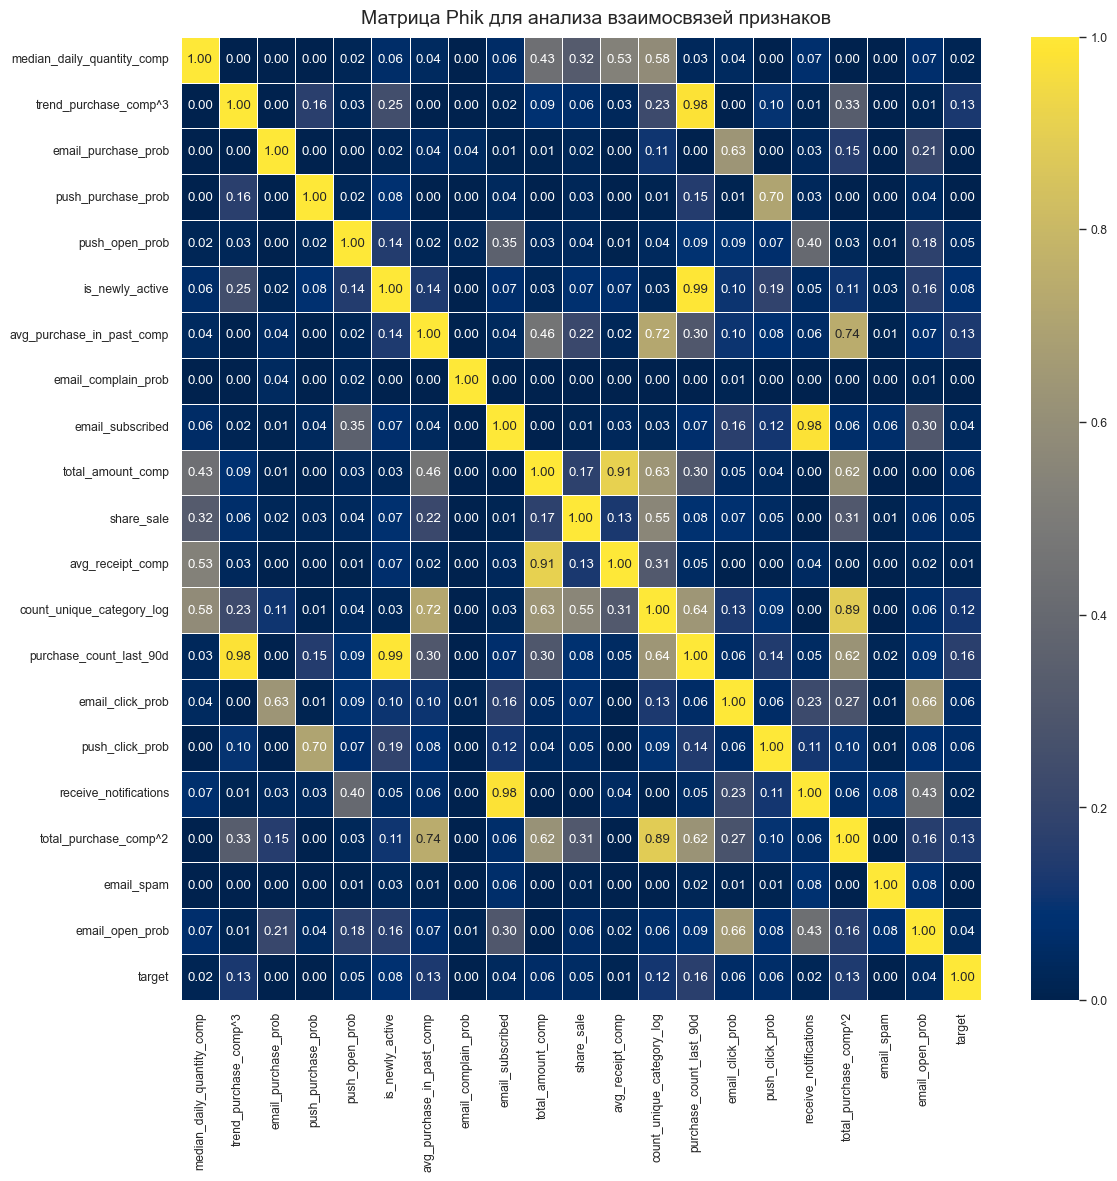

In [166]:
# Строим тепловую карту
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data[work_feature].phik_matrix(interval_cols=interval_cols), annot=True, 
            fmt='.2f', linewidths=.5, cmap='cividis', ax=ax)

# Настройка заголовка и подписей
f.suptitle('Матрица Phik для анализа взаимосвязей признаков', fontsize=14)

# Отображаем график
plt.tight_layout()
plt.show()

Признак `total_amount_comp` имеет более сильную зависимость с `target`, оставляем этот признак, признак `avg_receipt_comp` убираем из набора входных признаков.

Мы игнорируем сильную корреляцию между количественными признаками, так как делаем анализ `VIF-фактора`, а сильную корреляцию между категориальными признаками считаем наоборот хорошим знаком, так как они могут в совокупности хорошо работать, так как признаки дополняют друг друга, а не дублируют.

Признаки, которые показывают нулевую зависимость с `target` оставляем, так как при взаимодействии с другими признаками они могут стать полезными для модели, при исследовательском анализе мы видели, что вероятность опредленных реакций на уведомления и письма могут уточнить местоположение в многомерном пространстве клиентов класса `1`.

In [167]:
# Обновляем списки признаков
raw_feature = ['total_amount', 'median_daily_quantity', 'avg_purchase_in_past', 
               'trend_purchase^3', 'total_purchase^2', 'count_unique_category']

drop_feature = ['trend_purchase', 'total_purchase', 'trend_purchase_comp', 
                'total_purchase_comp', 'avg_receipt', 'avg_receipt_comp']

work_feature = list(set(data.columns) - set(raw_feature) - set(drop_feature))

num_col = ['purchase_count_last_90d', 'share_sale', 'email_open_prob',
           'email_click_prob', 'email_purchase_prob', 'email_complain_prob',
           'push_open_prob', 'push_click_prob', 'push_purchase_prob', 
           'count_unique_category_log', 'total_amount_comp', 'median_daily_quantity_comp', 
           'avg_purchase_in_past_comp', 'trend_purchase_comp^3', 'total_purchase_comp^2']

#### VIF-фактор:

Дополнительно перепроверяем коэффициенты `VIF-фактора`.

In [168]:
vif_factor(data, num_col)

input attribute       vif
0      purchase_count_last_90d  2.656101
1                   share_sale  2.175136
2              email_open_prob  2.465348
3             email_click_prob  3.077163
4          email_purchase_prob  1.589835
5          email_complain_prob  1.001554
6               push_open_prob  1.446812
7              push_click_prob  2.196242
8           push_purchase_prob  2.010073
9    count_unique_category_log  7.681414
10           total_amount_comp  2.156767
11  median_daily_quantity_comp  3.392355
12   avg_purchase_in_past_comp  2.030685
13       trend_purchase_comp^3  2.363234
14       total_purchase_comp^2  2.911096

Признак `count_unique_category_log` все еще выделяется, возведем его значения в квадрат.

In [169]:
# Преобразование признака
data['count_unique_category_log^2'] = data['count_unique_category_log'] ** 2
data['count_unique_category^2'] = data['count_unique_category'] ** 2

In [170]:
# Обновляем списки признаков
raw_feature = ['total_amount', 'median_daily_quantity', 'avg_purchase_in_past', 
               'trend_purchase^3', 'total_purchase^2', 'count_unique_category^2']

drop_feature = ['trend_purchase', 'total_purchase', 'trend_purchase_comp', 
                'total_purchase_comp', 'avg_receipt', 'avg_receipt_comp',
                'count_unique_category', 'count_unique_category_log']

work_feature = sorted(list(set(data.columns) - set(raw_feature) - set(drop_feature)))

num_col = ['purchase_count_last_90d', 'share_sale', 'email_open_prob',
           'email_click_prob', 'email_purchase_prob', 'email_complain_prob',
           'push_open_prob', 'push_click_prob', 'push_purchase_prob', 
           'count_unique_category_log^2', 'total_amount_comp', 'median_daily_quantity_comp', 
           'avg_purchase_in_past_comp', 'trend_purchase_comp^3', 'total_purchase_comp^2']

In [171]:
vif_factor(data, num_col)

input attribute       vif
0       purchase_count_last_90d  2.656977
1                    share_sale  1.818142
2               email_open_prob  2.424543
3              email_click_prob  3.077501
4           email_purchase_prob  1.589414
5           email_complain_prob  1.001507
6                push_open_prob  1.392287
7               push_click_prob  2.184249
8            push_purchase_prob  2.009483
9   count_unique_category_log^2  4.908270
10            total_amount_comp  2.165376
11   median_daily_quantity_comp  3.360710
12    avg_purchase_in_past_comp  1.960387
13        trend_purchase_comp^3  2.365912
14        total_purchase_comp^2  3.209198

Мы полностью избавились от мультиколлинеарности. 

Можем приступать к обучению моделей.

## Обучение моделей:

### Подготовка данных:

#### Списки признаков:

- `work_feature` — основной список признаков;
- `input_feature` — список входных признаков;
- `num_col` - количественные признаки;
- `cat_col` — категориальные признаки;
- `raw_feature` — нескомпрессированные признаки;
- `drop_feature` — признаки, которые не используются для обучения моделей.

In [172]:
# Проверяем корректность списков признаков
set(work_feature) == set(data.columns) - set(drop_feature) - set(raw_feature)

True

In [173]:
# Проверяем корректность списков признаков
list(set(work_feature) - set(num_col) - set(cat_col))

['target']

In [174]:
# Список входных признаков
input_feature = num_col + cat_col

Списки составлены корректно.

#### Деление на тренировочные и тестовые данные:

In [175]:
# Входные признаки
X = data.drop('target', axis=1)
# Целевой признак
y = data['target']

In [176]:
# Деление на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE, 
    stratify=y
)

In [177]:
# Проверяем размеры выборок
print(f'Размер обучающей выборки: {X_train[input_feature].shape, y_train.shape}')
print(f'Размер тестовой выборки: {X_test[input_feature].shape, y_test.shape}')

Размер обучающей выборки: ((37386, 19), (37386,))
Размер тестовой выборки: ((12463, 19), (12463,))


Тренировочная и тестовая выборки разделены корректно.

### Пайплайны для обучения моделей:

#### Data_preprocessor:

In [178]:
'''
Объединение этапов подготовки данных.

1. cat - признаки бинарные, в кодировке не нуждаются.

2. num - масштабируем признаки num_col.
'''
data_preprocessor = ColumnTransformer(
    [
        ('cat', 'passthrough', cat_col), 
        ('num', StandardScaler(), num_col)
    ], remainder='drop'
)

#### Pipe_final:

In [179]:
'''
data_preprocessor + tofloat32 + models

1. preprocessor - подготовка данных c помощью data_preprocessor

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. models - инициализация модели.
'''

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor), 
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', LogisticRegression())
    ]
)

#### Словарь подбора гиперпараметров:

In [180]:
param_grid = [
    {
        'model': [DummyClassifier(strategy="most_frequent")], 
    },
    {
        'model': [LogisticRegression(max_iter=5000,
                                     solver='lbfgs',
                                     penalty='l2',
                                     class_weight='balanced',
                                     random_state=RANDOM_STATE)], 
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'tofloat32': ['passthrough'],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler()] 
    }, 
    {
        'model': [RandomForestClassifier(n_estimators=300, 
                                         class_weight='balanced',
                                         random_state=RANDOM_STATE)], 
        'model__max_depth': [5, 8, 10, 12, 15],
        'model__min_samples_split': [5, 10, 15, 20],
        'model__min_samples_leaf': [1, 2, 5, 10],
        'preprocessor': ['passthrough']
    }, 
    {
        'model': [LGBMClassifier(n_estimators=300,
                                 max_depth=6, 
                                 subsample=0.8, 
                                 colsample_bytree=0.8, 
                                 class_weight='balanced',
                                 verbosity=-1,
                                 random_state=RANDOM_STATE)], 
        'model__num_leaves': [15, 31, 63, 127],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__min_data_in_leaf': [10, 20, 50, 100], 
        'preprocessor': ['passthrough']
    },
    {
        'model': [CatBoostClassifier(iterations=300, 
                                     subsample=0.8,
                                     auto_class_weights='Balanced',
                                     random_state=RANDOM_STATE,
                                     verbose=0)], 
        'model__max_depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__min_data_in_leaf': [10, 20, 50, 100],
        'preprocessor': ['passthrough']
    }
]

### Подбор лучших гиперпараметров моделей:

In [181]:
gs = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=3, 
    scoring='roc_auc',
    n_jobs=1
)
gs.fit(X_train[input_feature], y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         'passthrough',
                                                                         ['email_spam',
                                                                          'email_subscribed',
                                                                          'is_newly_active',
                                                                          'receive_notifications']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['purchase_count_last_90d',
                                                                          'share_sale',
                                                                          'email_open_prob',
                                                                          'email_click_prob',
                                                                          'email_purchase_prob',
                                                                          'email_complain_prob',
                                                                          'push_open_prob...
                          'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                          'model__min_data_in_leaf': [10, 20, 50, 100],
                          'model__num_leaves': [15, 31, 63, 127],
                          'preprocessor': ['passthrough']},
                         {'model': [<catboost.core.CatBoostClassifier object at 0x33270f2d0>],
                          'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
                          'model__max_depth': [4, 6, 8],
                          'model__min_data_in_leaf': [10, 20, 50, 100],
                          'preprocessor': ['passthrough']}],
             scoring='roc_auc')

In [182]:
best_result(gs)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
157       0.529616      0.035206         0.003614        0.000228   
0         0.008025      0.003007         0.003973        0.002365   
105       0.146959      0.001608         0.023155        0.001002   
11        0.034895      0.002682         0.006062        0.000912   
25        1.774183      0.004957         0.063254        0.001289   

                                                                                                                                                                         param_model  \
157                                                                                                                         <catboost.core.CatBoostClassifier object at 0x33270f2d0>   
0                                                                                                                                          DummyClassifier(strategy='most_frequent')   
105  LGBMClassifier(class_weight='balanced', colsample_bytree=0.8, max_depth=6,\n               n_estimators=300, random_state=6011994, subsample=0.8,\n               verbosity=-1)   
11                                                                                                  LogisticRegression(class_weight='balanced', max_iter=5000, random_state=6011994)   
25                                                                   RandomForestClassifier(class_weight='balanced', n_estimators=300,\n                       random_state=6011994)   

     param_model__C param_preprocessor__num param_tofloat32  \
157             NaN                     NaN             NaN   
0               NaN                     NaN             NaN   
105             NaN                     NaN             NaN   
11            100.0        StandardScaler()     passthrough   
25              NaN                     NaN             NaN   

     param_model__max_depth  param_model__min_samples_leaf  \
157                     4.0                            NaN   
0                       NaN                            NaN   
105                     NaN                            NaN   
11                      NaN                            NaN   
25                      5.0                           10.0   

     param_model__min_samples_split param_preprocessor  \
157                             NaN        passthrough   
0                               NaN                NaN   
105                             NaN        passthrough   
11                              NaN                NaN   
25                              5.0        passthrough   

     param_model__learning_rate  param_model__min_data_in_leaf  \
157                        0.01                           10.0   
0                           NaN                            NaN   
105                        0.01                          100.0   
11                          NaN                            NaN   
25                          NaN                            NaN   

     param_model__num_leaves  \
157                      NaN   
0                        NaN   
105                     15.0   
11                       NaN   
25                       NaN   

                                                                                                                                                                                                                                                                                                             params  \
157                                                                                                                          {'model': <catboost.core.CatBoostClassifier object at 0x33270f2d0>, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__min_data_in_leaf': 10, 'preprocessor': 'passthrough'}   
0                                                                                                                                                                           

Мы подобрали гиперпараметры для моделей, теперь можем приступать к поиску оптимального набора признаков.

### Подбор оптимального набора признаков:

В виду того, что все модели показали схожий результат, продолжаем работать со всеми.

In [183]:
# Списки признаков
rfe_feature = sorted(list(set(X_train.columns) - set(drop_feature)))
rfe_num_col = sorted(list(set(rfe_feature) - set(cat_col)))

#### LogisticRegression:

In [184]:
# Препроцессор для подбора признаков
'''
Объединение этапов подготовки данных.

1. cat - признаки бинарные, в кодировке не нуждаются.

2. num - масштабируем признаки ref_num_col.
'''
rfe_data_preprocessor = ColumnTransformer(
    [
        ('cat', 'passthrough', cat_col), 
        ('num', StandardScaler(), rfe_num_col)
    ], remainder='drop'
)

In [185]:
# Подготовим данные для LogisticRegression
X_preprocessed = rfe_data_preprocessor.fit_transform(X_train)
X_preprocessed = pd.DataFrame(X_preprocessed, columns=rfe_data_preprocessor.get_feature_names_out())

In [186]:
# Подбор признаков
rfecv = RFECV(
    estimator=LogisticRegression(max_iter=5000, 
                                 solver='lbfgs',
                                 penalty='l2',
                                 C=100,
                                 class_weight='balanced', 
                                 random_state=RANDOM_STATE),
    step=1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), 
    scoring='roc_auc', 
    n_jobs=1
)

rfecv.fit(X_preprocessed, y_train)

linear_features = (np.array(rfe_feature)[rfecv.support_]).tolist()
print("Оптимальное число признаков:", rfecv.n_features_)
print("Отобранные признаки:", linear_features)

Оптимальное число признаков: 17
Отобранные признаки: ['avg_purchase_in_past_comp', 'count_unique_category_log^2', 'email_click_prob', 'email_open_prob', 'email_purchase_prob', 'email_spam', 'median_daily_quantity', 'median_daily_quantity_comp', 'purchase_count_last_90d', 'push_click_prob', 'push_open_prob', 'push_purchase_prob', 'receive_notifications', 'total_amount', 'total_amount_comp', 'total_purchase^2', 'total_purchase_comp^2']


#### RandomForestClassifier:

In [187]:
# Подбор признаков
rfecv = RFECV(
    estimator=RandomForestClassifier(n_estimators=300, 
                                     class_weight='balanced',
                                     max_depth=5, 
                                     min_samples_leaf=10, 
                                     min_samples_split=5,
                                     random_state=RANDOM_STATE),
    step=1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), 
    scoring='roc_auc', 
    n_jobs=1
)

rfecv.fit(X_train[rfe_feature], y_train)

rf_features = (np.array(rfe_feature)[rfecv.support_]).tolist()
print("Оптимальное число признаков:", rfecv.n_features_)
print("Отобранные признаки:", rf_features)

Оптимальное число признаков: 15
Отобранные признаки: ['avg_purchase_in_past', 'avg_purchase_in_past_comp', 'count_unique_category^2', 'count_unique_category_log^2', 'email_click_prob', 'email_open_prob', 'purchase_count_last_90d', 'push_click_prob', 'push_open_prob', 'push_purchase_prob', 'total_amount', 'total_purchase^2', 'total_purchase_comp^2', 'trend_purchase^3', 'trend_purchase_comp^3']


#### LGBMClassifier:

In [188]:
# Подавляем предупреждение
warnings.filterwarnings("ignore", message="X does not have valid feature names.*")

In [189]:
# Подбор признаков
rfecv = RFECV(
    estimator=LGBMClassifier(n_estimators=300,
                             max_depth=6, 
                             subsample=0.8, 
                             colsample_bytree=0.8, 
                             learning_rate=0.01, 
                             min_data_in_leaf=100, 
                             num_leaves=15,
                             class_weight='balanced',
                             verbosity=-1,
                             random_state=RANDOM_STATE),
    step=1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), 
    scoring='roc_auc', 
    n_jobs=1
)

rfecv.fit(X_train[rfe_feature], y_train)

lgbm_features = (np.array(rfe_feature)[rfecv.support_]).tolist()
print("Оптимальное число признаков:", rfecv.n_features_)
print("Отобранные признаки:", lgbm_features)

Оптимальное число признаков: 14
Отобранные признаки: ['avg_purchase_in_past', 'count_unique_category^2', 'email_click_prob', 'email_open_prob', 'email_purchase_prob', 'median_daily_quantity', 'purchase_count_last_90d', 'push_click_prob', 'push_open_prob', 'push_purchase_prob', 'total_amount', 'total_amount_comp', 'total_purchase^2', 'trend_purchase^3']


#### CatBoostClassifier:

In [190]:
# Подбор признаков
rfecv = RFECV(
    estimator=CatBoostClassifier(iterations=300, 
                                 subsample=0.8,
                                 learning_rate=0.01, 
                                 max_depth=6, 
                                 min_data_in_leaf=10,
                                 auto_class_weights='Balanced',
                                 thread_count=1,
                                 random_state=RANDOM_STATE,
                                 verbose=0),
    step=1, 
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE), 
    scoring='roc_auc', 
    n_jobs=1
)

rfecv.fit(X_train[rfe_feature], y_train)

cat_features = (np.array(rfe_feature)[rfecv.support_]).tolist()
print("Оптимальное число признаков:", rfecv.n_features_)
print("Отобранные признаки:", cat_features)

Оптимальное число признаков: 16
Отобранные признаки: ['avg_purchase_in_past', 'count_unique_category^2', 'email_click_prob', 'email_open_prob', 'email_purchase_prob', 'email_subscribed', 'median_daily_quantity', 'purchase_count_last_90d', 'push_click_prob', 'push_open_prob', 'push_purchase_prob', 'total_amount_comp', 'total_purchase^2', 'total_purchase_comp^2', 'trend_purchase^3', 'trend_purchase_comp^3']


### Финальное обучение моделей и подбор гиперпараметров:

Мы подобрали оптимальные наборы признаков для каждой модели, теперь нам необходимо уточнить гиперпараметры для моделей снова и выбрать лучшую из них.

In [191]:
# Корректируем списки для ColumnTransformer
cat_col = sorted([col for col in linear_features if col in cat_col])
num_col = sorted(list(set(linear_features) - set(cat_col)))

#### LogisticRegression:

In [192]:
# Обновление data_preprocessor'a
'''
Объединение этапов подготовки данных.

1. cat - признаки бинарные, в кодировке не нуждаются.

2. num - масштабируем признаки num_col.
'''
data_preprocessor = ColumnTransformer(
    [
        ('cat', 'passthrough', cat_col), 
        ('num', StandardScaler(), num_col)
    ], remainder='drop'
)

In [193]:
# Пайплайн для обучения моделей
'''
select + data_preprocessor + model

1. select - отбор оптимального набора признаков для модели.

2. preprocessor - подготовка данных c помощью data_preprocessor.

3. model - инициализация модели.
'''

pipe_lr = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[linear_features], validate=False)),
        ('preprocessor', data_preprocessor), 
        ('model', LogisticRegression(max_iter=5000, 
                                     solver='lbfgs',
                                     penalty='l2',
                                     class_weight='balanced', 
                                     random_state=RANDOM_STATE))
    ]
)

In [194]:
# Словарь для поиска гиперпараметров
param_lr = {
    'model__C': Real(0.01, 100, prior='log-uniform'), 
    'preprocessor__num': Categorical([StandardScaler(), MinMaxScaler()])
}

In [195]:
# Инициализация поиска гиперпараметров
bayes_lr = BayesSearchCV(
    pipe_lr, 
    param_lr, 
    n_iter=50, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-3, 
    random_state=RANDOM_STATE
)

#### RandomForestClassifier:

In [196]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_rf = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[rf_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', RandomForestClassifier(n_estimators=300, 
                                         class_weight='balanced',
                                         n_jobs=1,
                                         random_state=RANDOM_STATE))
    ]
)

In [197]:
# Словарь для поиска гиперпараметров
param_rf = {
    'model__max_depth': Integer(3, 15),
    'model__min_samples_split': Integer(5, 20),
    'model__min_samples_leaf': Integer(1, 10)
}

In [198]:
# Инициализация поиска гиперпараметров
bayes_rf = BayesSearchCV(
    pipe_rf, 
    param_rf, 
    n_iter=50,
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-3, 
    random_state=RANDOM_STATE
)

#### LGBMClassifier:

In [199]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_lgbm = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[lgbm_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', LGBMClassifier(n_estimators=300,
                                 max_depth=6, 
                                 subsample=0.8, 
                                 colsample_bytree=0.8, 
                                 class_weight='balanced',
                                 verbosity=-1,
                                 n_jobs=1,
                                 random_state=RANDOM_STATE))
    ]
)

In [200]:
# Словарь для поиска гиперпараметров
param_lgbm = {
    'model__num_leaves': Integer(5, 127),
    'model__learning_rate': Real(0.01, 0.2, prior='log-uniform'),
    'model__min_data_in_leaf': Integer(10, 150)
}

In [201]:
# Инициализация поиска гиперпараметров
bayes_lgbm = BayesSearchCV(
    pipe_lgbm, 
    param_lgbm, 
    n_iter=50, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-3, 
    random_state=RANDOM_STATE
)

#### CatBoostClassifier:

In [202]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_cat = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[cat_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', CatBoostClassifier(iterations=300, 
                                     subsample=0.8,
                                     auto_class_weights='Balanced',
                                     thread_count=1,
                                     random_state=RANDOM_STATE,
                                     verbose=0))
    ]
)

In [203]:
# Словарь для подбора гиперпараметров
param_cat = {
    'model__max_depth': Integer(4, 8),
    'model__learning_rate': Real(0.01, 0.2, prior='log-uniform'), 
    'model__min_data_in_leaf': Integer(5, 100)
}

In [204]:
# Инициализация поиска гиперпараметров
bayes_cat = BayesSearchCV(
    pipe_cat, 
    param_cat, 
    n_iter=50, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-3, 
    random_state=RANDOM_STATE
)

#### Обучение моделей и их сравнение:

In [205]:
# Словари для хранения результатов и лучших моделей
results_data = []
best_estimators = {}

models = [
    ('LogisticRegression', bayes_lr),
    ('RandomForest', bayes_rf),
    ('LGBM', bayes_lgbm),
    ('CatBoost', bayes_cat)
]

In [206]:
# Цикл обучения моделей
for name, search in models:
    print('=' * 55)
    print(f'Обучение модели: {name}.')
    search.fit(X_train, y_train)
    
    # Сохраняем лучшую модель (пайплайн)
    best_estimators[name] = search.best_estimator_
    
    # Сохраняем результаты обучения
    results_data.append({
        'Model': name,
        'Best CV Score': search.best_score_,
        'Best Params': search.best_params_
    })
    
    print(f'Лучшая метрика на кросс-валидации: {search.best_score_:.4f}')
    print(f'Лучшие гиперпараметры: {search.best_params_}')

Обучение модели: LogisticRegression.
Лучшая метрика на кросс-валидации: 0.7193
Лучшие гиперпараметры: OrderedDict([('model__C', 50.65046884147651), ('preprocessor__num', StandardScaler())])
Обучение модели: RandomForest.
Лучшая метрика на кросс-валидации: 0.7219
Лучшие гиперпараметры: OrderedDict([('model__max_depth', 5), ('model__min_samples_leaf', 10), ('model__min_samples_split', 5)])
Обучение модели: LGBM.
Лучшая метрика на кросс-валидации: 0.7340
Лучшие гиперпараметры: OrderedDict([('model__learning_rate', 0.01), ('model__min_data_in_leaf', 115), ('model__num_leaves', 11)])
Обучение модели: CatBoost.
Лучшая метрика на кросс-валидации: 0.7408
Лучшие гиперпараметры: OrderedDict([('model__learning_rate', 0.023240397170906913), ('model__max_depth', 4), ('model__min_data_in_leaf', 50)])


In [207]:
# Вывод результатов обучения
results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Best CV Score', ascending=False).reset_index(drop=True)
results_df[['Model', 'Best CV Score']]

Model  Best CV Score
0            CatBoost       0.740782
1                LGBM       0.733999
2        RandomForest       0.721883
3  LogisticRegression       0.719278

Метрики все еще примерно на том же уровне, реализуем ансамбль этих моделей, для улучшения их предсказательной способности.

> ***Примечание:***
>
> Логистическая регрессия на этом этапе показала метрику немного хуже, чем на `GridSearchCV`, но остальные тесты показали, что по какой-то причине там получились слишком оптимистичные результаты, на кросс-валидации подобранные на `RFECV` набор признаков и гиперпараметры на `BayesSearchCV` показывают стабильно лучший результат указанный выше.

### Обучение ансамбля моделей:

#### Общий список признаков для моделей:

In [208]:
ensemble_features = sorted(set(linear_features + rf_features + lgbm_features + cat_features))

#### Обновление пайплайнов моделей:

##### LogisticRegression:

In [209]:
best_param_lr = bayes_lr.best_estimator_.named_steps['model']

In [210]:
# Обновление data_preprocessor'a
'''
Объединение этапов подготовки данных.

1. cat - признаки бинарные, в кодировке не нуждаются.

2. num - масштабируем признаки num_col.
'''
data_preprocessor = ColumnTransformer(
    [
        ('cat', 'passthrough', cat_col), 
        ('num', StandardScaler(), num_col)
    ], remainder='drop'
)

In [211]:
# Пайплайн для обучения моделей
'''
select + data_preprocessor + model

1. select - отбор оптимального набора признаков для модели.

2. preprocessor - подготовка данных c помощью data_preprocessor.

3. model - инициализация модели.
'''

pipe_lr = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[linear_features], validate=False)),
        ('preprocessor', data_preprocessor), 
        ('model', LogisticRegression(max_iter=5000, 
                                     solver='lbfgs',
                                     penalty='l2',
                                     C=best_param_lr.C,
                                     class_weight='balanced', 
                                     random_state=RANDOM_STATE))
    ]
)

##### RandomForestClassifier:

In [212]:
best_param_rf = bayes_rf.best_estimator_.named_steps['model']

In [213]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_rf = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[rf_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', RandomForestClassifier(n_estimators=300, 
                                         max_depth=best_param_rf.max_depth, 
                                         min_samples_leaf=best_param_rf.min_samples_leaf,
                                         min_samples_split=best_param_rf.min_samples_split,
                                         class_weight='balanced',
                                         n_jobs=1,
                                         random_state=RANDOM_STATE))
    ]
)

##### LGBMClassifier:

In [214]:
best_param_lgbm = bayes_lgbm.best_estimator_.named_steps['model']

In [215]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_lgbm = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[lgbm_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', LGBMClassifier(n_estimators=300,
                                 max_depth=6, 
                                 subsample=0.8, 
                                 learning_rate=best_param_lgbm.learning_rate, 
                                 num_leaves=best_param_lgbm.num_leaves,
                                 min_data_in_leaf=best_param_lgbm.min_data_in_leaf,
                                 colsample_bytree=0.8, 
                                 class_weight='balanced',
                                 verbosity=-1,
                                 n_jobs=1,
                                 random_state=RANDOM_STATE))
    ]
)

##### CatBoostClassifier:

In [216]:
best_param_cat = bayes_cat.best_estimator_.named_steps['model'].get_params()

In [217]:
# Пайплайн для обучения моделей
'''
select + tofloat32 + model

1. select - отбор оптимального набора признаков для модели.

2. tofloat32 - преобразование типов данных, для ускорения расчетов.

3. model - инициализация модели.
'''

pipe_cat = Pipeline(
    [
        ('select', FunctionTransformer(lambda X: X[cat_features], validate=False)),
        ('tofloat32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('model', CatBoostClassifier(iterations=300, 
                                     subsample=0.8,
                                     learning_rate=best_param_cat['learning_rate'],
                                     max_depth=best_param_cat['max_depth'], 
                                     min_data_in_leaf=best_param_cat['min_data_in_leaf'],
                                     auto_class_weights='Balanced',
                                     thread_count=1,
                                     random_state=RANDOM_STATE,
                                     verbose=0))
    ]
)

#### Инициализация ансамбля моделей:

In [218]:
# Инициализация модели
ensemble_clf = VotingClassifier(
    estimators=[('lr', pipe_lr), 
                ('rf', pipe_rf), 
                ('lgbm', pipe_lgbm), 
                ('cat', pipe_cat)],
    voting='soft'
)

#### Обучение модели:

In [219]:
# Задаем явно деление на фолды для надежности
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Оценка модели на кросс-валидации
cv_scores = cross_val_score(
    ensemble_clf, 
    X_train[ensemble_features], 
    y_train, 
    cv=cv, 
    scoring='roc_auc'
)
# Вывод результатов
print(f'Метрика ROC_AUC на кросс-валидации: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Метрика ROC_AUC на кросс-валидации: 0.7318 ± 0.0078


Метрика осталась на том же уровне, но стандартное отклонение метрики уменьшилось относительно первых результатов по каждой модели, выбор, как лучшую модель выберем данный ансамбль, в виду ее стабильности в метрике и тот же уровень качества, что и модели по отдельности.

In [220]:
# Обучение модели на всех данных
ensemble_clf.fit(X_train[ensemble_features], y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('select',
                                               FunctionTransformer(func=<function <lambda> at 0x332fed800>)),
                                              ('preprocessor',
                                               ColumnTransformer(transformers=[('cat',
                                                                                'passthrough',
                                                                                ['email_spam',
                                                                                 'receive_notifications']),
                                                                               ('num',
                                                                                StandardScaler(),
                                                                                ['avg_purchase_in_past_comp',
                                                                                 'count_unique_category_log^2',
                                                                                 'email_click_prob',
                                                                                 'email_open_prob',
                                                                                 '...
                                                              min_data_in_leaf=115,
                                                              n_estimators=300,
                                                              n_jobs=1,
                                                              num_leaves=11,
                                                              random_state=6011994,
                                                              subsample=0.8,
                                                              verbosity=-1))])),
                             ('cat',
                              Pipeline(steps=[('select',
                                               FunctionTransformer(func=<function <lambda> at 0x332fecea0>)),
                                              ('tofloat32',
                                               FunctionTransformer(func=<function <lambda> at 0x332fed080>)),
                                              ('model',
                                               <catboost.core.CatBoostClassifier object at 0x3493b4810>)]))],
                 voting='soft')

#### Оценка модели на тестовых данных:

In [221]:
# Предсказание на тестовых данных
pred = ensemble_clf.predict(X_test[ensemble_features])
pred_proba = ensemble_clf.predict_proba(X_test[ensemble_features])

# Оценка модели
print(f'Метрика Precision на тестовых данных: {precision_score(y_test, pred):.4f}')
print(f'Метрика Recall на тестовых данных: {recall_score(y_test, pred):.4f}')
print(f"Метрика PR-AUC на тестовых данных: {average_precision_score(y_test, pred_proba[:, 1]):.4f}")
print(f'Метрика ROC_AUC на тестовых данных: {roc_auc_score(y_test, pred_proba[:, 1]):.4f}')

Метрика Precision на тестовых данных: 0.0526
Метрика Recall на тестовых данных: 0.6458
Метрика PR-AUC на тестовых данных: 0.1033
Метрика ROC_AUC на тестовых данных: 0.7649


Визуализируем результаты:

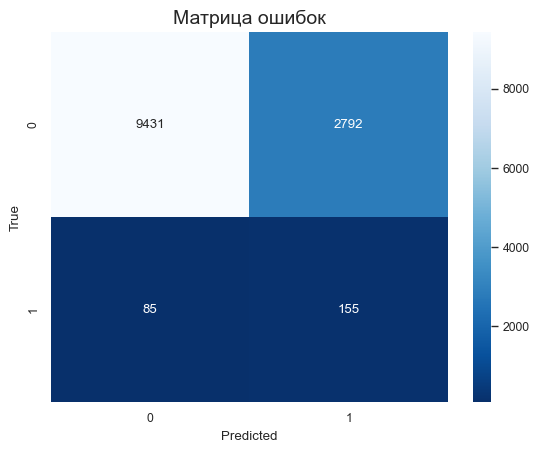

In [222]:
# Рассмотрим матрицу ошибок
cm = confusion_matrix(y_test, pred)
matrix_plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')

# Настройка заголовка и подписей
plt.title('Матрица ошибок', fontsize=14)
plt.xlabel('Predicted')
plt.ylabel('True')
    
# Вывод результатов
plt.show()

Исходя из метрик, можно сделать вывод, что модель улавливает слабый, но реальный сигнал: её `PR-AUC (0.103)` примерно **в 5 раз выше**, чем у случайной модели (ожидаемый `baseline ≈ 0.02` при доле положительного класса **2%**).

Модель успешно находит **64%** всех истинных положительных клиентов (`Recall = 0.645`), однако почти все её предсказания положительного класса ошибочны: лишь **5.2%** из клиентов, помеченных как класс `1`, действительно принадлежат этому классу (`Precision = 0.052`). Данная картина возникает при сильном дисбалансе классов.

Несмотря на низкую точность, такой результат — хорошая отправная точка. Для улучшения качества необходимо: 

- Оптимизировать модель по метрике PR-AUC (Average Precision);
- Более детально подойти к подбору весов для классов, провести эксперименты для улучшения результата;
- При необходимости — применить техники балансировки выборки.

### Вывод:

На данном этапе была обучена ансамблевая модель бинарной классификации с алгоритмом `soft_voting`, где каждая базовая модель обучена на индивидуальном наборе признаков полученный с помощью `RFECV`. Модель была выбрана благодаря стабильности её качества (стандартное отклонение `ROC-AUC` на кросс-валидации `≈ 0.0078`), не смотря на то, что показывает сопоставимое качество с отдельными моделями `LightGBM` и `CatBoost`. Ниже описание входных признаков для каждой модели и их лучшие гиперпараметры.

**Базовые модели внутри ансаибля:**

`LogisticRegression:`

Входные признаки:

- `avg_purchase_in_past_comp`
- `count_unique_category_log^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `email_spam`
- `median_daily_quantity`
- `median_daily_quantity_comp`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `receive_notifications`
- `total_amount`
- `total_amount_comp`
- `total_purchase^2`
- `total_purchase_comp^2`

Гиперпараметры модели:

```
{max_iter=5000, 
 solver='lbfgs',
 penalty='l2',
 C=50.65,
 class_weight='balanced'}
```

`RandomForestClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `avg_purchase_in_past_comp`
- `count_unique_category^2`
- `count_unique_category_log^2`
- `email_click_prob`
- `email_open_prob`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount`
- `total_purchase^2`
- `total_purchase_comp^2`
- `trend_purchase^3`
- `trend_purchase_comp^3`
 
Гиперпараметры модели:

```
{n_estimators=300, 
 max_depth=5, 
 min_samples_leaf=10,
 min_samples_split=5,
 class_weight='balanced'}
```

`LGBMClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `count_unique_category^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `median_daily_quantity`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount`
- `total_amount_comp`
- `total_purchase^2`
- `trend_purchase^3`

Гиперпараметры модели:

```
{n_estimators=300,
 max_depth=6, 
 subsample=0.8, 
 learning_rate=0.01, 
 num_leaves=11,
 min_data_in_leaf=115,
 colsample_bytree=0.8, 
 class_weight='balanced'}
```

`CatBoostClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `count_unique_category^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `email_subscribed`
- `median_daily_quantity`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount_comp`
- `total_purchase^2`
- `total_purchase_comp^2`
- `trend_purchase^3`
- `trend_purchase_comp^3`

Гиперпараметры модели:

```
{iterations=300, 
 subsample=0.8,
 learning_rate=0.023,
 max_depth=4, 
 min_data_in_leaf=50,
 auto_class_weights='Balanced'}
```

**Метрики ансамблевой модели:**

- Метрика Precision на тестовых данных: `0.0526`
- Метрика Recall на тестовых данных: `0.6458`
- Метрика PR-AUC на тестовых данных: `0.1033`
- Метрика ROC_AUC на тестовых данных: `0.7649`

Исходя из метрик, можно сделать вывод, что модель улавливает слабый, но реальный сигнал: её `PR-AUC (0.103)` примерно **в 5 раз выше**, чем у случайной модели (ожидаемый `baseline ≈ 0.02` при доле положительного класса **2%**).

Модель успешно находит **64%** всех истинных положительных клиентов (`Recall = 0.645`), однако почти все её предсказания положительного класса ошибочны: лишь **5.2%** из клиентов, помеченных как класс `1`, действительно принадлежат этому классу (`Precision = 0.052`), что типично при сильном дисбалансе классов.

Несмотря на низкую точность, такой результат — хорошая отправная точка. Для улучшения качества необходимо: 

- Оптимизировать модель по метрике `PR-AUC` (`Average Precision`);
- Более детально подойти к подбору весов для классов, провести эксперименты для улучшения результата;
- При необходимости — применить техники балансировки выборки.

## Интерпретация модели с помощью SHAP:

In [223]:
# Получим подвыборку из тестовых данных для SHAP
X_shap, _, y_shap, _ = train_test_split(
    X_test, y_test,
    train_size=1000, 
    stratify=y_test,
    random_state=RANDOM_STATE
)

In [224]:
# Расчитываем SHAP-значения
explainer = shap.Explainer(ensemble_clf.predict_proba, X_shap[ensemble_features])

shap_values = explainer(X_shap[ensemble_features])

PermutationExplainer explainer: 1001it [05:44,  2.84it/s]                       


### Строим графики для анализа:

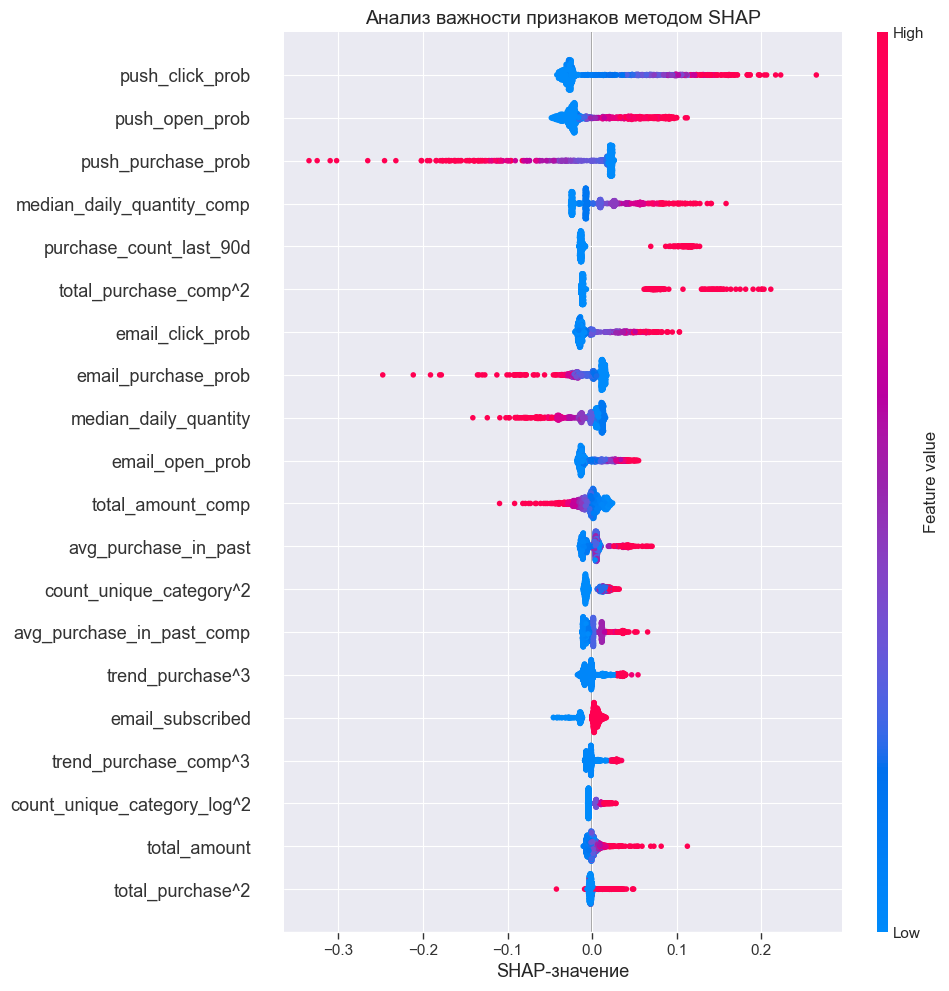

In [225]:
# Строим график важности признаков
shap.summary_plot(
    shap_values[:, :, 1], 
    X_shap[ensemble_features], 
    rng=np.random.default_rng(42),
    feature_names=ensemble_features,
    show=False
)
# Получаем текущие оси
ax = plt.gca()

# Меняем размер графика
plt.gcf().set_size_inches(10, 10)

# Настройка заголовка и подписей
plt.title('Анализ важности признаков методом SHAP', fontsize=14)
plt.xlabel('SHAP-значение')

# Вывод графика
plt.tight_layout()
plt.show()

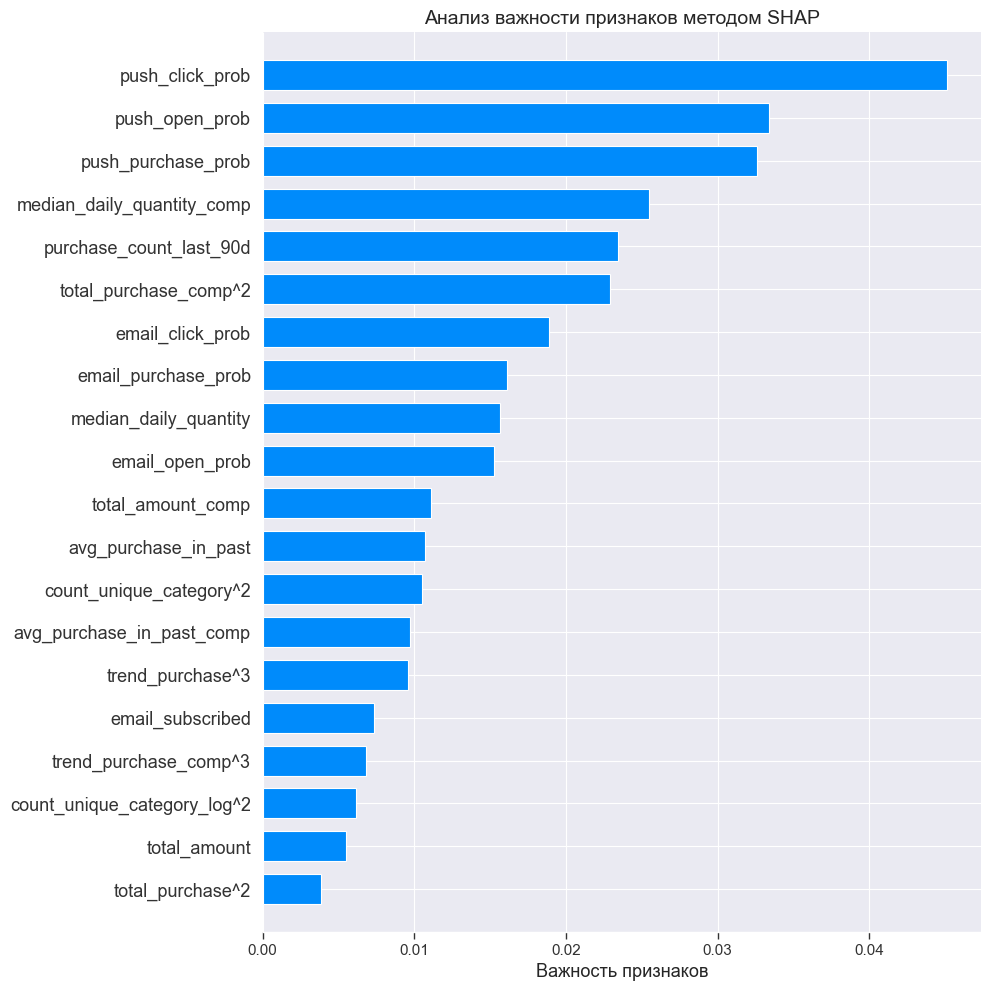

In [226]:
# Строим график важности признаков (столбчатый график)
shap.summary_plot(
    shap_values[:, :, 1], 
    X_shap[ensemble_features], 
    plot_type='bar',
    rng=np.random.default_rng(42),
    feature_names=ensemble_features,
    show=False
)
# Получаем текущие оси
ax = plt.gca()

# Меняем размер графика
plt.gcf().set_size_inches(10, 10)

# Настройка заголовка и подписей
plt.title('Анализ важности признаков методом SHAP', fontsize=14)
plt.xlabel('Важность признаков')

# Вывод графика
plt.tight_layout()
plt.show()

### Вывод:

Наиболее важными признаками являются те, которые характеризуют:

- Вероятность реакции клиента на `push-уведомления` или `email`;
- Среднее количество единиц товара за покупку у клиента;
- Количество покупок в разные периоды (всего, последний квартал).

## Общий вывод:

### Описание проекта:

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель проекта** — Предсказать вероятность покупки в течение `90 дней`.

**Описание данных:**

`apparel-purchases.csv` — Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента;
- `quantity` — количество единиц товара;
- `price` — цена товара;
- `category_ids` — идентификаторы категорий;
- `date` — дата покупки;
- `message_id` — идентификатор сообщения из рассылки.

>***Примечание к таблице:***
>
>*В таблице есть списки идентификаторов, к каким категориям относится товар. Часто
это вложенные категории (например: `автотовары-аксессуары-освежители`), но также может
включать в начале списка маркер распродажи или маркер `женщинам/мужчинам`.*
>
>*Нумерация категорий сквозная для всех уровней, то есть `44` на второй позиции списка
или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому
могут меняться вложенности, например `['4', '28', '44', '1594']` или `['4', '44', '1594']`.*

---

`apparel-messages.csv` — Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки;
- `client_id` — идентификатор клиента;
- `message_id` — идентификатор сообщения;
- `event` — действие с сообщением *(`отправлено, открыто, покупка и т.д.`)*
- `channel` — канал рассылки;
- `date` — дата действия;
- `created_at` — дата-время полностью.

---

`target.csv` — Целевой признак.

- `client_id` — идентификатор клиента;
- `target` — клиент совершил покупку в целевом периоде.

---

`full_campaign_daily_event.csv` — Агрегация общей базы рассылок по дням и типам событий.

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event*` — общее количество каждого события `event`;
- `nunique_event*` — количество уникальных `client_id` в каждом событии.


> ***Примечание к таблице:***
> 
>`*` — в именах колонок все типы событий `event`.

---

`full_campaign_daily_event_channel.csv` — Агрегация по дням с учетом событий и каналов рассылки.

- `date` — дата;
- `bulk_campaign_id` — идентификатор рассылки;
- `count_event*_channel*` — общее количество каждого события по каналам;
- `nunique_event*_channel*` — количество уникальных `client_id` по событиям и каналам.


> ***Примечание к таблице:***
> 
>`*` — в именах колонок есть все типы событий `event` и каналов рассылки `channel`.

**Ход исследования:**

- `Подготовка данных`: загрузка и изучение общей информации из представленных датасетов.


- `Предобработка данных и агрегирование признаков:`: агрегирование признаков для обучения моделей из сырых данных.


- `Исследовательский анализ данных`: изучение признаков, их распределение, поиск выбросов/аномалий в данных.


- `Корреляционный анализ`: изучение взимосвязей между входными признаками и целевыми, а также и между ними.


- `Использование пайплайнов`: написание пайплайнов для подготовки данных и обучения модели для упрощения и ускорения поиска лучшей модели и ее гиперпараметров.


- `Поиск лучшей модели`: грубый поиск лучших гиперпараметров с помощью `GridSearchCV`, поиск оптимального набора признака для моделей с помощью `RFECV`, более точный поиск лучших гиперпараметров и обучение моделей с помощью `BayesSearchCV`, обучение ансамблевой модели с применением `soft-voting`, тестирование итоговой модели и анализ результатов.


- `Анализ важности признаков`: анализ степени важности признаков их влияния на принятие решений моделью с помощью метода `SHAP`.


- `Общий вывод`: резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

### Результаты обучения моделей:

На данном этапе была обучена ансамблевая модель бинарной классификации с алгоритмом `soft_voting`, где каждая базовая модель обучена на индивидуальном наборе признаков полученный с помощью `RFECV`. Модель была выбрана благодаря стабильности её качества (стандартное отклонение `ROC-AUC` на кросс-валидации `≈ 0.0078`), не смотря на то, что показывает сопоставимое качество с отдельными моделями `LightGBM` и `CatBoost`. Ниже описание входных признаков для каждой модели и их лучшие гиперпараметры.

**Базовые модели внутри ансамбля:**

`LogisticRegression:`

Входные признаки:

- `avg_purchase_in_past_comp`
- `count_unique_category_log^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `email_spam`
- `median_daily_quantity`
- `median_daily_quantity_comp`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `receive_notifications`
- `total_amount`
- `total_amount_comp`
- `total_purchase^2`
- `total_purchase_comp^2`

Гиперпараметры модели:

```
{max_iter=5000, 
 solver='lbfgs',
 penalty='l2',
 C=50.65,
 class_weight='balanced'}
```

`RandomForestClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `avg_purchase_in_past_comp`
- `count_unique_category^2`
- `count_unique_category_log^2`
- `email_click_prob`
- `email_open_prob`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount`
- `total_purchase^2`
- `total_purchase_comp^2`
- `trend_purchase^3`
- `trend_purchase_comp^3`
 
Гиперпараметры модели:

```
{n_estimators=300, 
 max_depth=5, 
 min_samples_leaf=10,
 min_samples_split=5,
 class_weight='balanced'}
```

`LGBMClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `count_unique_category^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `median_daily_quantity`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount`
- `total_amount_comp`
- `total_purchase^2`
- `trend_purchase^3`

Гиперпараметры модели:

```
{n_estimators=300,
 max_depth=6, 
 subsample=0.8, 
 learning_rate=0.01, 
 num_leaves=11,
 min_data_in_leaf=115,
 colsample_bytree=0.8, 
 class_weight='balanced'}
```

`CatBoostClassifier:`

Входные признаки:

- `avg_purchase_in_past`
- `count_unique_category^2`
- `email_click_prob`
- `email_open_prob`
- `email_purchase_prob`
- `email_subscribed`
- `median_daily_quantity`
- `purchase_count_last_90d`
- `push_click_prob`
- `push_open_prob`
- `push_purchase_prob`
- `total_amount_comp`
- `total_purchase^2`
- `total_purchase_comp^2`
- `trend_purchase^3`
- `trend_purchase_comp^3`

Гиперпараметры модели:

```
{iterations=300, 
 subsample=0.8,
 learning_rate=0.023,
 max_depth=4, 
 min_data_in_leaf=50,
 auto_class_weights='Balanced'}
```

**Метрики ансамблевой модели:**

- Метрика Precision на тестовых данных: `0.0526`
- Метрика Recall на тестовых данных: `0.6458`
- Метрика PR-AUC на тестовых данных: `0.1033`
- Метрика ROC_AUC на тестовых данных: `0.7649`

### Интерпретация модели с помощью SHAP:

Наиболее важными признаками являются те, которые характеризуют:

- Вероятность реакции клиента на `push-уведомления` или `email`;
- Среднее количество единиц товара за покупку у клиента;
- Количество покупок в разные периоды (всего, последний квартал).

### Обобщение и рекомендации:

Исходя из метрик, можно сделать вывод, что модель улавливает слабый, но реальный сигнал: её `PR-AUC (0.103)` примерно **в 5 раз выше**, чем у случайной модели (ожидаемый `baseline ≈ 0.02` при доле положительного класса **2%**).

Модель успешно находит **64%** всех истинных положительных клиентов (`Recall = 0.645`), однако почти все её предсказания положительного класса ошибочны: лишь **5.2%** из клиентов, помеченных как класс `1`, действительно принадлежат этому классу (`Precision = 0.052`), что типично при сильном дисбалансе классов.

Несмотря на низкую точность, такой результат — хорошая отправная точка. Для улучшения качества необходимо: 

- Оптимизировать модель по метрике `PR-AUC` (`Average Precision`);
- Более детально подойти к подбору весов для классов, провести эксперименты для улучшения результата;
- При необходимости — применить техники балансировки выборки.